# <center>Credit EDA Case Study<center/>


# 1. ESSENTIAL IMPORTS & SETTINGS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Don't want pandas to truncate the output of all our 122 cols. 
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# 2. SOME FUNCTIONS

In [4]:
def IdentifyNulls(df):
    totalLen = df.shape[0]
    nulls = df.isnull().sum()
    nulls = nulls.reset_index()
    nulls.columns = ['Name', 'Nulls']
    nulls['Percentage'] = nulls['Nulls']*100 / totalLen  # Calc percentage of null values in each column
    nulls.sort_values('Percentage', ascending=False, inplace=True)
    print(nulls.head(200))

In [5]:
# in_df:            The input (original) data frame. 
# in_columnList:    List of Numerical variable names. 
def MakeHeatMap(in_df, in_columnList):
    corr_matrix = in_df[in_columnList].corr()
    # Now Plot the Heatmap. 
    cm_min = min(corr_matrix.min())*1.1
    cm_max = max(corr_matrix.max())*1.1
    plt.figure(figsize=(15,10))
    plt.subplot(1,1,1)
    sns.set_context("paper", font_scale=1.4)
    ax1 = sns.heatmap(data=corr_matrix, cmap='Blues', annot=True, fmt='.2f',  xticklabels=in_columnList, 
                      vmin=cm_min, vmax=cm_max)
    ax1.set(title="Correlation Matrix HeatMap", xlabel="Variables")
    plt.show()
        

In [6]:
def Top10Correlations(df):
    corr_mat = df.corr()
    corr = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool))
    corr = corr.abs().unstack().reset_index()
    corr.columns = ['V1', 'V2', 'Correlation']
    corr.dropna(subset=['Correlation'], inplace=True)
    output = corr.sort_values(by='Correlation', ascending=False).head(10)
    print(output)


In [7]:
def MakeBarPlot_CategoryVars_vs_Target(df):
    columns = df.columns
    
    for col in columns:
        if col == 'TARGET': continue
        
        uniqVals = df[col].unique().tolist()
        uniqVals = list(map(str, uniqVals)) # ensure they are all strings (eg., "0", "1" ...)
        uniqVals_num = len(uniqVals)
        longestValue = max(uniqVals, key = len)
        longestValueLen = len(longestValue)
        
        df_grp = df.groupby([col, 'TARGET']).agg(count_col=pd.NamedAgg(column=col, aggfunc="count") )
        df_grp = df_grp.reset_index()
        df_grp.rename(columns = {'count_col':'Count'}, inplace = True)

        xsize = 10; ysize = 5; xlabel_angle = 0
        if uniqVals_num > 10:
            xsize = 20; 
            if longestValueLen > 5: xlabel_angle = 90
        elif uniqVals_num > 5:
            xsize = 15; 
            if longestValueLen > 5: xlabel_angle = 90
        else:
            if longestValueLen > 10: xlabel_angle = 90
        
        plt.figure(figsize=(xsize,ysize))
        
        chart = sns.barplot(data=df_grp, x=col, y="Count", hue='TARGET')
        chart.set_xticklabels(chart.get_xticklabels(), rotation=xlabel_angle)
        plt.show()
        print("\n")

In [8]:
def GetSample(columnsList):
    df0 = ad_T_0[columnsList].sample(n=2000, replace=False)
    df1 = ad_T_1[columnsList].sample(n=2000, replace=False)
    df = pd.concat([df0, df1], axis=0)
    return df

In [9]:
def BiVariateCategoryPlot(df, v1, v2, xLabelAngle):
    # First get a random sample from df. 
    dfs = ad[[v1, v2, 'TARGET']].sample(n=50000, replace=False)
    plt.figure(figsize=(10,6), dpi=80)
    sns.barplot(x=v1, y='TARGET',data=dfs, hue=v2, palette='Set2')
    plt.title(f"{v1} vs. {v2}")
    plt.xticks(rotation=xLabelAngle)
    plt.tight_layout
    plt.show()

# 3. READ THE DATA FILES

In [10]:
ad= pd.read_csv("application_data.csv")
pa= pd.read_csv("previous_application.csv")

In [11]:
ad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [12]:
ad.describe()

SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307499.000000     3.072330e+05   
mean   5.990260e+05   27108.573909     5.383962e+05   
std    4.024908e+05   14493.737315     3.694465e+05   
min    4.500000e+04    1615.500000     4.050000e+04   
25%    2.700000e+05   16524.000000     2.385000e+05   
50%    5.135310e+05   24903.000000     4.500000e+05   
75%    8.086500e+05   34596.000000     6.795000e+05   
max    4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  \
count               307511.000000  307511.000000  307511.000000   
mean                     0.020868  -16036.995067   63815.045904   
std                      0.013831    4363.988632  141275.766519   
min                      0.000290  -25229.000000  -17912.000000   
25%                      0.010006  -19682.000000   -2760.000000   
50%                      0.018850  -15750.000000   -1213.000000   
75%                      0.028663  -12413.000000    -289.000000   
max                      0.072508   -7489.000000  365243.000000   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH    OWN_CAR_AGE     FLAG_MOBIL  \
count      307511.000000    307511.000000  104582.000000  307511.000000   
mean        -4986.120328     -2994.202373      12.061091       0.999997   
std          3522.886321      1509.450419      11.944812       0.001803   
min        -24672.000000     -7197.000000       0.000000       0.000000   
25%         -7479.500000     -4299.000000       5.000000       1.000000   
50%         -4504.000000     -3254.000000       9.000000       1.000000   
75%         -2010.000000     -1720.000000      15.000000       1.000000   
max             0.000000         0.000000      91.000000       1.000000   

       FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE     FLAG_PHONE  \
count   307511.000000    307511.000000     307511.000000  307511.000000   
mean         0.819889         0.199368          0.998133       0.281066   
std          0.384280         0.399526          0.043164       0.449521   
min          0.000000         0.000000          0.000000       0.000000   
25%          1.000000         0.000000          1.000000       0.000000   
50%          1.000000         0.000000          1.000000       0.000000   
75%          1.000000         0.000000          1.000000       1.000000   
max          1.000000         1.000000          1.000000       1.000000   

          FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
count  307511.000000    307509.000000         307511.000000   
mean        0.056720         2.152665              2.052463   
std         0.231307         0.910682              0.509034   
min         0.000000         1.000000              1.000000   
25%         0.000000         2.000000              2.000000   
50%         0.000000         2.000000              2.000000   
75%         0.000000         3.000000              2.000000   
max         1.000000        20.000000              3.000000   

       REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
count                307511.000000            307511.000000   
mean                      2.031521                12.063419   
std                       0.502737                 3.265832   
min                       1.000000                 0.000000   
25%                       

In [13]:
ad.shape

(307511, 122)

In [14]:
# Check null value percentage in all columns in application data
chk_null_allcol_ad=ad.isnull().sum()*100/len(ad)
chk_null_allcol_ad.sort_values(ascending=False).head()# check for head(55) till is more missing values

COMMONAREA_MEDI             69.872297
COMMONAREA_AVG              69.872297
COMMONAREA_MODE             69.872297
NONLIVINGAPARTMENTS_MODE    69.432963
NONLIVINGAPARTMENTS_AVG     69.432963
dtype: float64

# 4. DATA CLEANING

## 4.1 Handling Null Values

In [15]:
# check for the null value percetage in all columns in previous application
chk_null_allcol_pa=pa.isnull().sum()*100/len(pa)
chk_null_allcol_pa.sort_values(ascending=False).head()# check for head(12) till is more missing values

RATE_INTEREST_PRIVILEGED    99.643698
RATE_INTEREST_PRIMARY       99.643698
AMT_DOWN_PAYMENT            53.636480
RATE_DOWN_PAYMENT           53.636480
NAME_TYPE_SUITE             49.119754
dtype: float64

In [16]:
# Check for the columns which have null value more than 50 percent in application data
row_count_50per_ad=ad.shape[0]/2
chk_cols_nullgt50_ad = ad.columns[ad.isnull().sum() > row_count_50per_ad]
print("Total null  columns more then 50% null value in application data:",len(chk_cols_nullgt50_ad))

Total null  columns more then 50% null value in application data: 41


In [17]:
# Check for the columns which have null value more than 50 percent in previous application
row_count_50per_pa = pa.shape[0]/2
chk_cols_nullgt50_pa = pa.columns[pa.isnull().sum() > row_count_50per_pa]
print("Total null  columns more then 50% null value in previous application:",len(chk_cols_nullgt50_pa))

Total null  columns more then 50% null value in previous application: 4


In [18]:
# Dropping the columns which have more then 50% of data in application data
ad = ad.drop(chk_cols_nullgt50_ad, axis=1)

In [19]:
# Dropping the columns which have more then 50% of data in previous application
pa = pa.drop(chk_cols_nullgt50_pa,axis=1)

In [20]:
# Check the shape for both data
print("shape for application data:",ad.shape)
print("shape for application data:",pa.shape)

shape for application data: (307511, 81)
shape for application data: (1670214, 33)


#### After eliminating all columns with >50% missing values, we will analyze remaining columns.  
#### Eg., Occupation column has almost 31% missing values, but this will be an important variable for analysis. 

In [21]:
# We will check if the credit bureau check variables have any correlation with Target (Approved/Rejected).

creditChkCols = [
        'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
        'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

ad[creditChkCols].corrwith(ad['TARGET'])

AMT_REQ_CREDIT_BUREAU_HOUR    0.000930
AMT_REQ_CREDIT_BUREAU_DAY     0.002704
AMT_REQ_CREDIT_BUREAU_WEEK    0.000788
AMT_REQ_CREDIT_BUREAU_MON    -0.012462
AMT_REQ_CREDIT_BUREAU_QRT    -0.002022
AMT_REQ_CREDIT_BUREAU_YEAR    0.019930
dtype: float64

In [22]:
# We see almost negligible correlation of these columns with TARGET column.  Hence, we will elminate these columns as well. 
ad = ad.drop(columns = creditChkCols)

In [23]:
# categorical columns in application_data dataset
category_clmns_ad = ['SK_ID_CURR','TARGET','OCCUPATION_TYPE', 'NAME_CONTRACT_TYPE','CODE_GENDER',
                    'FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_TYPE_SUITE','NAME_INCOME_TYPE',
                    'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE',
                    'FLAG_MOBIL','FLAG_EMP_PHONE','FLAG_WORK_PHONE',
                    'FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL','ORGANIZATION_TYPE',
                    'REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION',
                    'REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY',
                    'REG_REGION_NOT_LIVE_REGION',
                    'HOUR_APPR_PROCESS_START','WEEKDAY_APPR_PROCESS_START',
                    'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
                    'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
                    'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
                    'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
                    'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
                    'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
                    'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']

# Non-categorical columns in application_data dataset
non_category_clmns_ad = ['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE',
                        'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
                        'REGION_POPULATION_RELATIVE','DAYS_BIRTH','CNT_FAM_MEMBERS','CNT_CHILDREN','DAYS_EMPLOYED', 
                        'DAYS_REGISTRATION','DAYS_ID_PUBLISH',
                        'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 
                        'DEF_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE', 
                        'DEF_60_CNT_SOCIAL_CIRCLE','DAYS_LAST_PHONE_CHANGE']

# categorical columns in previous_application dataset
category_clmns_pa = ['SK_ID_PREV', 'SK_ID_CURR','NAME_CONTRACT_TYPE', 'HOUR_APPR_PROCESS_START','WEEKDAY_APPR_PROCESS_START',
                    'FLAG_LAST_APPL_PER_CONTRACT','NFLAG_LAST_APPL_IN_DAY','NAME_CASH_LOAN_PURPOSE',
                    'NAME_CONTRACT_STATUS','NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 
                    'NAME_CLIENT_TYPE','NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
                    'CHANNEL_TYPE', 'NAME_SELLER_INDUSTRY','NAME_YIELD_GROUP', 'PRODUCT_COMBINATION']

# Non-categorical columns in previous_application dataset
non_category_clmns_pa = ['AMT_APPLICATION','AMT_CREDIT','DAYS_DECISION', 'SELLERPLACE_AREA']

In [24]:
# Identify columns with  null values and see what all can be dropped. 
IdentifyNulls(ad)

                            Name   Nulls  Percentage
43                 FLOORSMAX_AVG  153020   49.760822
45                FLOORSMAX_MODE  153020   49.760822
47                FLOORSMAX_MEDI  153020   49.760822
42   YEARS_BEGINEXPLUATATION_AVG  150007   48.781019
44  YEARS_BEGINEXPLUATATION_MODE  150007   48.781019
46  YEARS_BEGINEXPLUATATION_MEDI  150007   48.781019
48                TOTALAREA_MODE  148431   48.268517
49           EMERGENCYSTATE_MODE  145755   47.398304
27               OCCUPATION_TYPE   96391   31.345545
41                  EXT_SOURCE_3   60965   19.825307
11               NAME_TYPE_SUITE    1292    0.420148
50      OBS_30_CNT_SOCIAL_CIRCLE    1021    0.332021
51      DEF_30_CNT_SOCIAL_CIRCLE    1021    0.332021
52      OBS_60_CNT_SOCIAL_CIRCLE    1021    0.332021
53      DEF_60_CNT_SOCIAL_CIRCLE    1021    0.332021
40                  EXT_SOURCE_2     660    0.214626
10               AMT_GOODS_PRICE     278    0.090403
9                    AMT_ANNUITY      12    0.

In [25]:
# We see that there are still a few REALTY related columns (with close to 50% missing values). 
# Most of the other REALTY columns had already been dropped. We will drop these columns as well.
Leftover_Realty_Columns = [ 'FLOORSMAX_AVG', 'FLOORSMAX_MODE', 'FLOORSMAX_MEDI',
                        'YEARS_BEGINEXPLUATATION_AVG','YEARS_BEGINEXPLUATATION_MODE',
                        'YEARS_BEGINEXPLUATATION_MEDI','TOTALAREA_MODE', 'EMERGENCYSTATE_MODE', ]

ad = ad.drop(columns = Leftover_Realty_Columns)

In [26]:
# Columns with less than 1% null values: (Drop rows with null values in these columns as they will not impact EDA)
cols2Check = ['NAME_TYPE_SUITE', 
'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 
'EXT_SOURCE_2', 'AMT_GOODS_PRICE', 'AMT_ANNUITY', 'CNT_FAM_MEMBERS', 'DAYS_LAST_PHONE_CHANGE']

rowsToDrop = list(np.where(ad[cols2Check].isnull())[0])
ad = ad.drop(ad.index[rowsToDrop])

In [27]:
# Finding the list of actual null columns from the dataframes ad ,that contains all columns which has less than 50% Null values

clmn_ad_null_cate = [i for i in ad.columns[ad.isna().any()].tolist() if i in category_clmns_ad]
print("\nList of all categorical columns that has actual missing values in among less than 50% null value columns in application_data: ", clmn_ad_null_cate)

clmn_ad_null_noncat=[i for i in ad.columns[ad.isna().any()].tolist() if i in non_category_clmns_ad]
print("\n\nList of all non categorical columns that has actual missing values in among less than 50% null value columns in application_data: ", clmn_ad_null_noncat)


List of all categorical columns that has actual missing values in among less than 50% null value columns in application_data:  ['OCCUPATION_TYPE']


List of all non categorical columns that has actual missing values in among less than 50% null value columns in application_data:  ['EXT_SOURCE_3']


In [28]:
# Finding the list of actual null columns from the dataframes pa, 
# that contains all columns which has less than 50% Null values

clmn_pa_null_cate = [i for i in pa.columns[pa.isna().any()].tolist() if i in category_clmns_pa]
print("List of all categorical columns that has actual missing values (less than 50% null values) in previous_data: ", clmn_pa_null_cate)

clmn_pa_null_noncat = [i for i in pa.columns[pa.isna().any()].tolist() if i in non_category_clmns_pa]
print("\nList of all non categorical columns that has actual missing values (less than 50% null values)  in previous_data: ", clmn_pa_null_noncat)

List of all categorical columns that has actual missing values (less than 50% null values) in previous_data:  ['PRODUCT_COMBINATION']

List of all non categorical columns that has actual missing values (less than 50% null values)  in previous_data:  ['AMT_CREDIT']


In [29]:
# In general, category variables are imputed with MODE values. 
# However, for variables like OCCUPATION or PRODUCT_COMBINATION, it would be better to represent missing values with XNA.

# Replacing null categorical variable with XNA in ad(application_data dataframe)
for i in clmn_ad_null_cate:
    ad[i].fillna('XNA', inplace=True)

# Replacing null categorical variable with XNA in pa(previous application dataframe)
for i in clmn_pa_null_cate:
    pa[i].fillna('XNA',inplace=True)

## 4.2 Finding Outliers

In [30]:
# Finding Outliers
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

num_ad = ad.select_dtypes(include=numerics)
num_pa = pa.select_dtypes(include=numerics)

# We are not considering the numerical columns which are actually categorical, in detecting outliers.

categorical_num_columns_ad = ['SK_ID_CURR','TARGET','FLAG_MOBIL','FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_CONT_MOBILE',
                           'FLAG_PHONE','FLAG_EMAIL','FLAG_DOCUMENT_2','FLAG_DOCUMENT_3','FLAG_DOCUMENT_4','FLAG_DOCUMENT_5',
                           'FLAG_DOCUMENT_6','FLAG_DOCUMENT_7','FLAG_DOCUMENT_8','FLAG_DOCUMENT_9','FLAG_DOCUMENT_10',
                           'FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_13','FLAG_DOCUMENT_14','FLAG_DOCUMENT_15',
                           'FLAG_DOCUMENT_16','FLAG_DOCUMENT_17','FLAG_DOCUMENT_18','FLAG_DOCUMENT_19','FLAG_DOCUMENT_20',
                           'FLAG_DOCUMENT_21'] 

categorical_num_columns_pa = ['SK_ID_PREV','SK_ID_CURR','NFLAG_LAST_APPL_IN_DAY']

In [31]:
# Removing the numerical_categorical columns 
num_ad = num_ad.drop(columns=categorical_num_columns_ad)
num_pa = num_pa.drop(columns=categorical_num_columns_pa)
print(num_ad.columns)
print(num_pa.columns)

Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE'],
      dtype='object')
Index(['AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_GOODS_PRICE',
       'HOUR_APPR_PROCESS_START', 'DAYS_DECISION', 'SELLERPLACE_AREA',
       'CNT_PAYMENT', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE',
       'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINAT

In [32]:
# Identify columns with outliers (among the numeric columns). 

clmn_ad_non_cate_outlier = num_ad.columns[((num_ad.std()/num_ad.mean())*100).abs()>85].tolist()
print("Columns that has outliers in application_data.csv, \nwhich has a standard deviation of more than 85% from its mean:\n\n ", clmn_ad_non_cate_outlier)

clmn_pa_non_cate_outlier = num_pa.columns[((num_pa.std()/num_pa.mean())*100).abs()>85].tolist()
print("\nColumns that has outliers in previous_application.csv, \nwhich has a standard deviation of more than 85% from its mean:\n\n", clmn_pa_non_cate_outlier)

Columns that has outliers in application_data.csv, 
which has a standard deviation of more than 85% from its mean:

  ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_EMPLOYED', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE']

Columns that has outliers in previous_application.csv, 
which has a standard deviation of more than 85% from its mean:

 ['AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'DAYS_DECISION', 'SELLERPLACE_AREA', 'CNT_PAYMENT', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL']


In [33]:
# Identify outliers in above columns (we will make reasonable assumptions by looking at the data 
# rather than using IQR*1.5 as threshold of outliers).

ad[clmn_ad_non_cate_outlier].describe(percentiles=[0.99])


CNT_CHILDREN  AMT_INCOME_TOTAL  DAYS_EMPLOYED  \
count  304531.000000      3.045310e+05  304531.000000   
mean        0.417140      1.686634e+05   63831.232423   
std         0.722308      2.378910e+05  141291.148422   
min         0.000000      2.565000e+04  -17912.000000   
50%         0.000000      1.476000e+05   -1215.000000   
99%         3.000000      4.545000e+05  365243.000000   
max        19.000000      1.170000e+08  365243.000000   

       REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
count               304531.000000               304531.000000   
mean                     0.015154                    0.050675   
std                      0.122167                    0.219333   
min                      0.000000                    0.000000   
50%                      0.000000                    0.000000   
99%                      1.000000                    1.000000   
max                      1.000000                    1.000000   

       LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
count                304531.000000           304531.000000   
mean                      0.040518                0.078212   
std                       0.197171                0.268505   
min                       0.000000                0.000000   
50%                       0.000000                0.000000   
99%                       1.000000                1.000000   
max                       1.000000                1.000000   

       REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  \
count           304531.000000            304531.000000   
mean                 0.230630                 0.179709   
std                  0.421237                 0.383946   
min                  0.000000                 0.000000   
50%                  0.000000                 0.000000   
99%                  1.000000                 1.000000   
max                  1.000000                 1.000000   

       OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
count             304531.000000             304531.000000   
mean                   1.422052                  0.143421   
std                    2.401424                  0.446721   
min                    0.000000                  0.000000   
50%                    0.000000                  0.000000   
99%                   10.000000                  2.000000   
max                  348.000000                 34.000000   

       OBS_60_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE  \
count             304531.000000             304531.000000   
mean                   1.405131                  0.100069   
std                    2.380308                  0.362388   
min                    0.000000                  0.000000   
50%                    0.000000                  0.000000   
99%                   10.000000                  2.000000   
max                  344.000000                 24.000000   

       DAYS_LAST_PHONE_CHANGE  
count           304531.000000  
mean              -965.330085  
std                826.943447  
min              -4292.000000  
50%               -761.000000  
99%                  0.000000  
max                  0.000000

#### Observations: Outliers in AD categorical variables:

We see following fields of interest that potentially have outliers: 

| Field | Analysis | 
|:------|:---------|
| AMT_INCOME_TOTAL | However, some individuals are high net worth and can indeed have such income. So no outliers here. |
| DAYS_EMPLOYED    | There are values with 365243 (1000+ years) which are clearly wrong. |

Remaining columns seem to have plausible values. And we will not focus on them.  Our field of interest here is DAYS_EMPLOYED. 


In [34]:
# Analysing DAYS_EMPLOYED in Application Data
df = ad.loc[ad.DAYS_EMPLOYED > 0, ['DAYS_EMPLOYED']]
print(df.shape) # (54852, 1)

df = ad.loc[ad.DAYS_EMPLOYED == ad.DAYS_EMPLOYED.max(), ['DAYS_EMPLOYED']]
print(df.shape) # (54852, 1)

# The code above shows that all rows with DAYS_EMPLOYED > 0 are equal to 365243 (1000 years). 
# Since all legit values are -ve, this high +ve value is an indicator we don't have any data here. 

# However, this can skew the results significantly when taking 'mean' later on. 
# Hence, we will impute these values (+365243) usng the median so as to have minimum impact on our EDA. 
#  - We don't want to use "mean" here since it has already been highly skewed (~ 20+ years) by 50K+ values of 365243. 

median = ad.DAYS_EMPLOYED.median()
ad.DAYS_EMPLOYED.replace({365243: median}, inplace=True)
print("Imputing 365243 in DAYS_EMPLOYED with median value:", median)

del df # Reclaim some RAM memory. 
ad.DAYS_EMPLOYED.describe()

(54852, 1)
(54852, 1)
Imputing 365243 in DAYS_EMPLOYED with median value: -1215.0


count    304531.000000
mean      -2175.033658
std        2165.529078
min      -17912.000000
25%       -2762.000000
50%       -1215.000000
75%        -934.000000
max           0.000000
Name: DAYS_EMPLOYED, dtype: float64

In [35]:
# Now we do the same for the categorical variables in PA
pa[clmn_pa_non_cate_outlier].describe(percentiles=[0.99])

AMT_ANNUITY  AMT_APPLICATION    AMT_CREDIT  AMT_GOODS_PRICE  \
count  1.297979e+06     1.670214e+06  1.670213e+06     1.284699e+06   
mean   1.595512e+04     1.752339e+05  1.961140e+05     2.278473e+05   
std    1.478214e+04     2.927798e+05  3.185746e+05     3.153966e+05   
min    0.000000e+00     0.000000e+00  0.000000e+00     0.000000e+00   
50%    1.125000e+04     7.104600e+04  8.054100e+04     1.123200e+05   
99%    6.968579e+04     1.350000e+06  1.515378e+06     1.395000e+06   
max    4.180581e+05     6.905160e+06  6.905160e+06     6.905160e+06   

       DAYS_DECISION  SELLERPLACE_AREA   CNT_PAYMENT  DAYS_FIRST_DUE  \
count   1.670214e+06      1.670214e+06  1.297984e+06   997149.000000   
mean   -8.806797e+02      3.139511e+02  1.605408e+01    13826.269337   
std     7.790997e+02      7.127443e+03  1.456729e+01    72444.869708   
min    -2.922000e+03     -1.000000e+00  0.000000e+00    -2892.000000   
50%    -5.810000e+02      3.000000e+00  1.200000e+01     -831.000000   
99%    -1.400000e+01      3.570000e+03  6.000000e+01   365243.000000   
max    -1.000000e+00      4.000000e+06  8.400000e+01   365243.000000   

       DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE  DAYS_TERMINATION  \
count              997149.000000  997149.000000     997149.000000   
mean                33767.774054   76582.403064      81992.343838   
std                106857.034789  149647.415123     153303.516729   
min                 -2801.000000   -2889.000000      -2874.000000   
50%                  -361.000000    -537.000000       -499.000000   
99%                365243.000000  365243.000000     365243.000000   
max                365243.000000  365243.000000     365243.000000   

       NFLAG_INSURED_ON_APPROVAL  
count              997149.000000  
mean                    0.332570  
std                     0.471134  
min                     0.000000  
50%                     0.000000  
99%                     1.000000  
max                     1.000000

#### Observations of outliers in PA categorical variables: 
- In PA data, only the DAYS_#_DUE or DAYS_TERMINATION have outlier (initializer) values of 365243. 
- At this point, these columns do not seem likely candidates to impact default/no-default.  
- However, if at later stage, these columns show correlation to TARGET (0 / 1), then we will impute them with median values at that time. 

In [36]:
# Dealing with the missing values in non categoricalvariables that has outliers:

# Preparing a list containing null, non-categoricall variables containing outliers in application_data
clmn_ad_null_non_cate_outlier = [i for i in clmn_ad_null_noncat if i in clmn_ad_non_cate_outlier]
print(clmn_ad_non_cate_outlier)

# Preparing a list containing null, non-categoricall variables containing outliers in previous_application
clmn_pa_null_non_cate_outlier = [i for i in clmn_pa_null_noncat if i in clmn_pa_non_cate_outlier]
print(clmn_pa_null_non_cate_outlier)

['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_EMPLOYED', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE']
['AMT_CREDIT']


In [37]:
# Replacing null,non-categorical variable (having outliers) with median in application_data dataframe
for i in clmn_ad_null_non_cate_outlier:
    ad[i].fillna(ad[i].median(),inplace=True)


# Replacing null,non-categorical variable (having outliers) with median in previous_application dataframe
for i in clmn_pa_null_non_cate_outlier:
    pa[i].fillna(pa[i].median(),inplace=True)
    
    

In [38]:
#Dealing with missing values in non-categorical variables that does not have outliers

# Preparing a list containing null, non-categorical variables containing no outliers in application_data
clmn_ad_null_non_cate_no_outlier = [i for i in clmn_ad_null_noncat if i not in clmn_ad_null_non_cate_outlier]
print(clmn_ad_null_non_cate_no_outlier)

# Preparing a list containing null, non-categorical variables containing no outliers in previous_application
clmn_pa_null_non_cate_no_outlier = [i for i in clmn_pa_null_noncat if i not in clmn_pa_null_non_cate_outlier]
print(clmn_pa_null_non_cate_no_outlier)

['EXT_SOURCE_3']
[]


In [39]:
# We see there is still EXT_SOURCE_3 identified as a numerical column with null values. Let's impute null values with mean. 
ad.EXT_SOURCE_3.replace({np.NaN: ad.EXT_SOURCE_3.mean()}, inplace=True)
ad.EXT_SOURCE_3.isnull().sum() # Should give 0

0

In [40]:
# Replacing null,non-categorical variable (having no outliers) with mean in application_data dataframe
for i in clmn_ad_null_non_cate_no_outlier:
    ad[i].fillna(ad[i].mean(),inplace=True)
    
# Replacing null,non-categorical variable (having no outliers) with mean in previous_application dataframe
for i in clmn_pa_null_non_cate_no_outlier:
    pa[i].fillna(pa[i].mean(),inplace=True)

In [41]:
# Check if is there any null values left out

print('Is there any null values in df_application_data: ', ad.isnull().values.any())
print('Is there any null values in df_previous_application: ', pa.isnull().values.any())
       

Is there any null values in df_application_data:  False
Is there any null values in df_previous_application:  True


In [42]:
print(clmn_ad_null_non_cate_outlier)
print(clmn_pa_null_non_cate_outlier)

[]
['AMT_CREDIT']


In [43]:
# Check if indeed any nulls in AMT_CREDIT
pa.AMT_CREDIT.isnull().sum()
# Answer: 0.  So no nulls in AMT_CREDIT either. 

0

## 4.3 Convert Categorical Variables to Ordinal Data


The NAME_EDUCATION_TYPE column can be converted to ordinal data to show the level of education that a person has. 

In [44]:
edu_dict =  {'Academic degree':             5,
             'Higher education':            4,
            'Incomplete higher':            3, 
            'Secondary / secondary special':2,
            'Lower secondary':              1}

ad['EDUCATION_SCORE'] = ad.NAME_EDUCATION_TYPE.map(edu_dict)

ad.EDUCATION_SCORE.value_counts()

2    216582
4     73821
3     10175
1      3790
5       163
Name: EDUCATION_SCORE, dtype: int64

# 5. DATA ANALYSIS (Basic Preparations)

## 5.1 Handling Data Imbalance

#### Analysis to be carried out:
By Analysing the given datasets we could sense that the columns which gives direct information on the loan approval/rejection are 'Target' and 'NAME_CONTRACT_STATUS' repectively on 'application_data.csv' and 'Previous_application.csv'. Further, I'm gonna perform univariate and bi-variate analysis to get more insight on these columns and the co-relation with the other columns, so that, we can understand how loan approval/rejection is estimated, and which are the cariables influences this.

#### Finding if there is Imbalance in data
- As per our problem statement and with the given data sets we need to check whether a person will likely pay the loan amount or will become a defaulter. To find that we need to feed the data to our model with the help of the data sets provided to us.
- If the data is imbalanced, it means that one of the classifications (defaulters vs non-defaulters) will have excess amount of data compared to the other classes (eg. 10 times or more). 
- Since we are concerned with the 'TARGET' variable to detect whether to approve/reject loan, we are going to focus on finding if there is any imbalance on this variable.

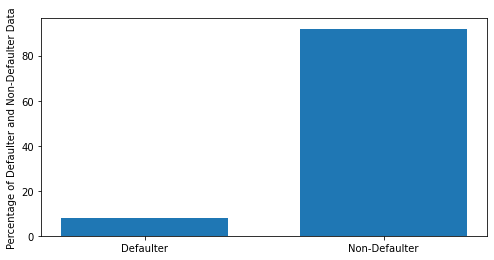

Ratios of imbalance in percentage with respect to non-defaulter and defaulter datas are: 91.900004 and 8.099996
Ratios of imbalance in real-numbers with respect to non-defaulter and defaulter datas is 11.345685 : 1 (approx)


In [45]:
count_1=0
count_0=0

for i in ad.TARGET.values:
    if i==1:
        count_1=count_1+1
    else:
        count_0=count_0+1

count_1_per= (count_1/(count_1+count_0))*100
count_0_per= (count_0/(count_1+count_0))*100

x=['Defaulter','Non-Defaulter']
y=[count_1_per,count_0_per]

plt.figure(figsize=[8,4])
plt.bar(x,y,width=0.7)
plt.ylabel('Percentage of Defaulter and Non-Defaulter Data')
plt.show()

print('Ratios of imbalance in percentage with respect to non-defaulter and defaulter datas are: %f and %f'%(count_0_per,count_1_per))
print('Ratios of imbalance in real-numbers with respect to non-defaulter and defaulter datas is %f : 1 (approx)'%(count_0/count_1))

From the above graph we can very clearly see that there is an imbalance between the defaulters data and the non-defaulters.
As mentioned earlier, imbalance of data will tend to create a biased model. 

- One of the best technique to avoid the curse of imbalanced data is by undersampling the larger classified dataset and by oversampling the less classified dataset. So that, the final dataset will have a balanced/equal number of data among all the labels.
- When possible, we could explore the data based only on percentages rather than absolute values. This too will deal with imbalanced data sets. 

## 5.2 Segmenting Data into Defaulters vs Non-Defaulters. 

Dividing the data into two sets, i.e. Target=1 and Target=0 for application_data

In [46]:
ad_T_0 = ad[ad.TARGET == 0]
ad_T_1 = ad[ad.TARGET == 1]


#### Dividing the data into two sets, i.e. Target=1 and Target=0 for previous_application dataset

Creating a target variable for the previous_application dataset. 
In order to create a target varible in prev_app_data we are going to consider the column: NAME_CONTRACT_STATUS
We are going classify the status 'Refused' as 1 and 'Approved' as 0. The reason for this assumption is that if the previous company rejects the loan for a person then the only reason for doing so is that the company would have sensed that the person might be having payment difficulties. On the other hand, if the previous company approved the loan for a person then the only reason would be that the company would have sensed that the person would not have any payment difficulties.
We are going to remove all other rows where the status is 'cancelled' or 'unused offer'

In [47]:
prev_target=[]

for i in pa['NAME_CONTRACT_STATUS'].tolist():
    if i=='Approved':
        prev_target.append(0)
    elif i=='Refused':
        prev_target.append(1)
    else:
        prev_target.append(None)
        
# Creting a 'Target' variable with  Approved = 0, Refused = 1, all other as Null
pa['TARGET']=prev_target

pa=pa.loc[(pa['TARGET']==1) | (pa['TARGET']==0)]
pa.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0          17145.0                   SATURDAY   
1    679671.0         607500.0                   THURSDAY   
2    136444.5         112500.0                    TUESDAY   
3    470790.0         450000.0                     MONDAY   
4    404055.0         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   
1                       11                           Y   
2                       11                           Y   
3                        7                           Y   
4                        9                           Y   

   NFLAG_LAST_APPL_IN_DAY NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                       1                    XAP             Approved   
1                       1                    XNA             Approved   
2                       1                    XNA             Approved   
3                       1                    XNA             Approved   
4                       1                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    XNA                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   
2         Repeater                 XNA           Cash            x-sell   
3         Repeater                 XNA           Cash            x-sell   
4         Repeater                 XNA           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  XNA   
2  Credit and cash offices                -1                  XNA   
3  Credit and cash offices                -1                  XNA   
4  Credit and cash offices                -1                  XNA   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0         12.0           middle  POS mobile with interest            365243.0   
1         36.0       low_action          Cash X-Sell: low            365243.0   
2         12.0             high         Cash X-Sell: high            365243.0   
3         12.0           middle       Cash X-Sell: middle            365243.0   
4         24.0             high         Cash Street: high                 NaN   

   DAYS_FIRST_DUE  DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE  DAYS_TERMINATION  \
0           -42.0                      300.0          -42.0             -37.0   
1          -134.0                      916.0       365243.0          365243.0   
2          -271.0                       59.0       365243.0          365243.0   
3          -482.0                     -152.0         -182.0            -177.0   
4             NaN                        NaN            NaN               NaN   

   NFLAG_INSURED_ON_APPROVAL  TARGET  
0                        

In [48]:
# Dividing the previous application data into two set
pa_T_0=pa[pa['TARGET']==0]
pa_T_1=pa[pa['TARGET']==1]

# 6. DATA ANALYSIS - Univariate Analysis

## 6.1 Univariate Analysis [ on Application Data (AD) & Previous Applications (PA) ]

### 5.3.1 Univariate Analysis on selected ordered-categorical variables that are common in both datasets

#### Univariate analysis on selected ordered-categorical variable ('WEEKDAY_APPR_PROCESS_START') in both datasets for Target = 1

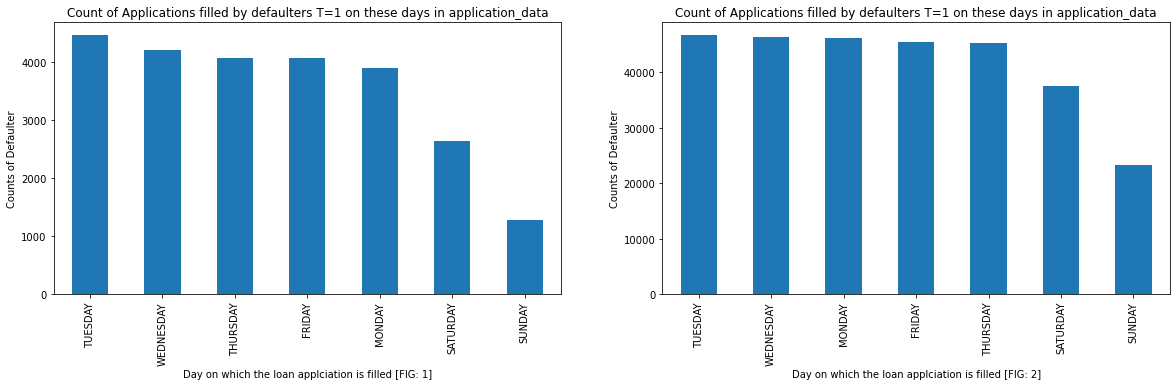

In [49]:
# For TARGET = 1
# Plotting the count and rank varaibles for WEEKDAY_APPR_PROCESS_START in both datasets for Target = 1

plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
ad_T_1['WEEKDAY_APPR_PROCESS_START'].value_counts().plot(kind='bar')
plt.title('Count of Applications filled by defaulters T=1 on these days in application_data')
plt.xlabel('Day on which the loan applciation is filled [FIG: 1]')
plt.ylabel('Counts of Defaulter')

plt.subplot(1,2,2)
pa_T_1['WEEKDAY_APPR_PROCESS_START'].value_counts().plot(kind='bar')
plt.title('Count of Applications filled by defaulters T=1 on these days in application_data')
plt.xlabel('Day on which the loan applciation is filled [FIG: 2]')
plt.ylabel('Counts of Defaulter')
plt.show()


#### Univariate analysis on selected ordered-categorical variable ('WEEKDAY_APPR_PROCESS_START') in both datasets for Target = 0

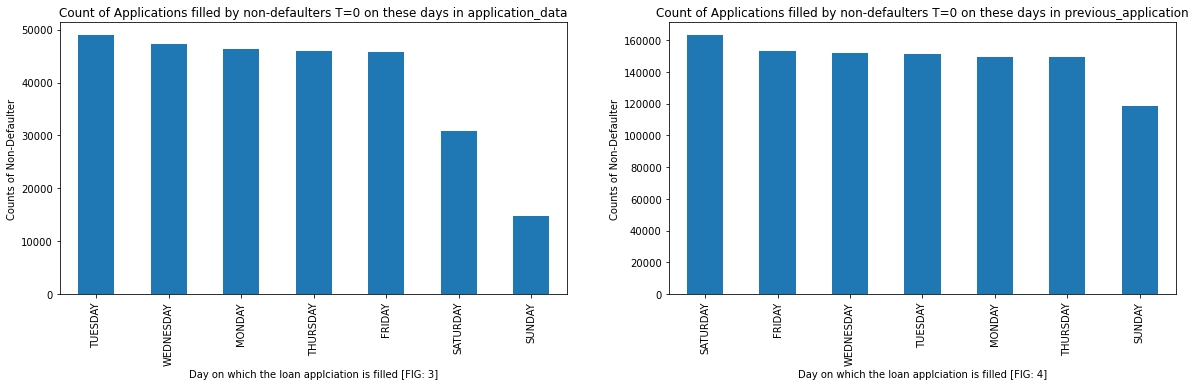

In [50]:
# For TARGET = 0
# Plotting the count and rank varaibles for WEEKDAY_APPR_PROCESS_START in both datasets for Target = 0

plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
ad_T_0['WEEKDAY_APPR_PROCESS_START'].value_counts().plot(kind='bar')
plt.title('Count of Applications filled by non-defaulters T=0 on these days in application_data')
plt.xlabel('Day on which the loan applciation is filled [FIG: 3]')
plt.ylabel('Counts of Non-Defaulter')

plt.subplot(1,2,2)
pa_T_0['WEEKDAY_APPR_PROCESS_START'].value_counts().plot(kind='bar')
plt.title('Count of Applications filled by non-defaulters T=0 on these days in previous_application')
plt.xlabel('Day on which the loan applciation is filled [FIG: 4]')
plt.ylabel('Counts of Non-Defaulter')
plt.show()

Analysis from above univariate analysis on WEEKDAY_APPR_PROCESS_START on both target variable 0 and 1 for both the data set :

FIG:1&2, shows that the maximum of defaulters who filled the application is on Tuesdays and the less number of applications filled is on Sunday.

FIG:3, shows the same pattern as above among non-defaulters too which is a total contradiction.

FIG:4, shows the similar pattern too where very less applications are filled on Sundays among non-defaulters.

##### Conclusion: We cannot decide much using the days of the week on which the applications are filled in identifying the defaulters, because both in the case of defaulters and non-defaulters the pattern followed is very similar. 

#### Univariate analysis on selected ordered-categorical variable ('HOUR_APPR_PROCESS_START') in both datasets for Target = 1

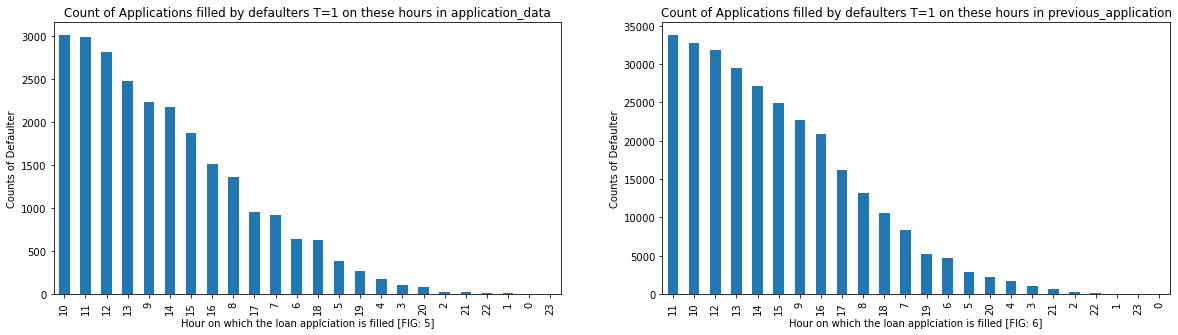

In [51]:

# Plotting the count and rank varaibles for HOUR_APPR_PROCESS_START in both datasets for Target = 1

plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
ad_T_1['HOUR_APPR_PROCESS_START'].value_counts().plot(kind='bar')
plt.title('Count of Applications filled by defaulters T=1 on these hours in application_data')
plt.xlabel('Hour on which the loan applciation is filled [FIG: 5]')
plt.ylabel('Counts of Defaulter')

plt.subplot(1,2,2)
pa_T_1['HOUR_APPR_PROCESS_START'].value_counts().plot(kind='bar')
plt.title('Count of Applications filled by defaulters T=1 on these hours in previous_application')
plt.xlabel('Hour on which the loan applciation is filled [FIG: 6]')
plt.ylabel('Counts of Defaulter')
plt.show()


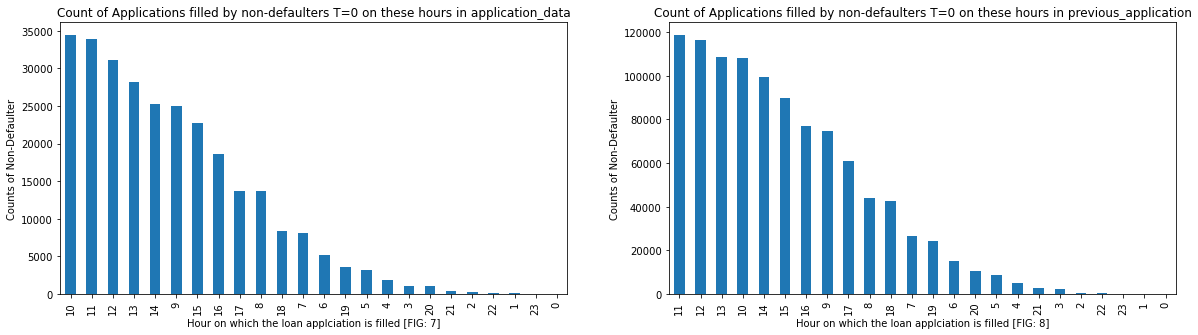

In [52]:
# Plotting the count and rank varaibles for HOUR_APPR_PROCESS_START in both datasets for Target = 0

plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
ad_T_0['HOUR_APPR_PROCESS_START'].value_counts().plot(kind='bar')
plt.title('Count of Applications filled by non-defaulters T=0 on these hours in application_data')
plt.xlabel('Hour on which the loan applciation is filled [FIG: 7]')
plt.ylabel('Counts of Non-Defaulter')

plt.subplot(1,2,2)
pa_T_0['HOUR_APPR_PROCESS_START'].value_counts().plot(kind='bar')
plt.title('Count of Applications filled by non-defaulters T=0 on these hours in previous_application')
plt.xlabel('Hour on which the loan applciation is filled [FIG: 8]')
plt.ylabel('Counts of Non-Defaulter')
plt.show()

Analysis from above:

FIG:5&6, shows that the maximum of defaulters who filled the application is on 10th and 11th hour.

FIG:7&8, shows the same pattern as above among non-defaulters too which is a total contradiction.

##### Conclusion: We cannot decide much using the hours on which the applications are filled in identifying the defaulters, because both in the case of defaulters and non-defaulters the pattern followed is very similar.

#### Univariate Analysis on selected ordered-categorical variables that are present in application_data datasets


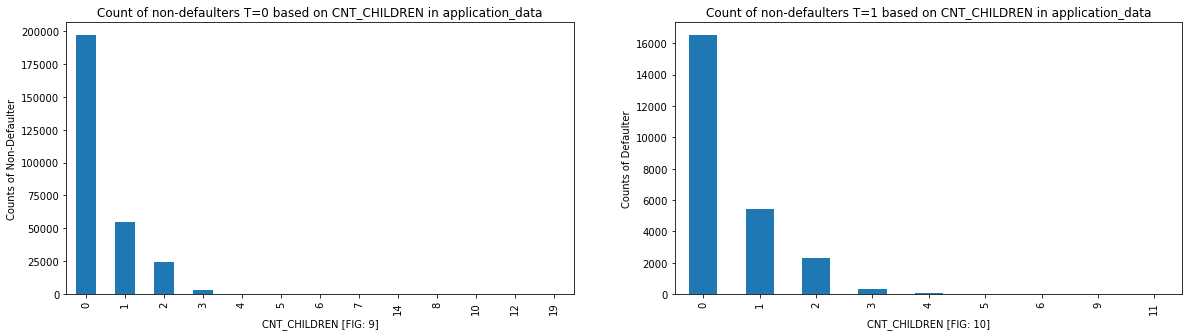

In [53]:
# Plotting the count and rank varaibles for CNT_CHILDREN in application_data datasets for Target = 0 and 1

plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
ad_T_0['CNT_CHILDREN'].value_counts().plot(kind='bar')
plt.title('Count of non-defaulters T=0 based on CNT_CHILDREN in application_data')
plt.xlabel('CNT_CHILDREN [FIG: 9]')
plt.ylabel('Counts of Non-Defaulter')

plt.subplot(1,2,2)
ad_T_1['CNT_CHILDREN'].value_counts().plot(kind='bar')
plt.title('Count of non-defaulters T=1 based on CNT_CHILDREN in application_data')
plt.xlabel('CNT_CHILDREN [FIG: 10]')
plt.ylabel('Counts of Defaulter')
plt.show()

Analysis from above:
    
FIG:9, shows the pattern where maximum number of non-defaulters are having 0 children while applying for the loan
    
FIG:10, shows that the maximum of the defaulters have 0 children while applying for the loan
    
##### Conclusion: We cannot decide much using CNT_Children in identifying the defaulters, because both in the case of defaulters and non-defaulters the pattern followed is the same.

#### Univariate analysis on selected ordered-categorical variable ('NAME_EDUCATION_TYPE') in application_data datasets for Target = 0 and 1


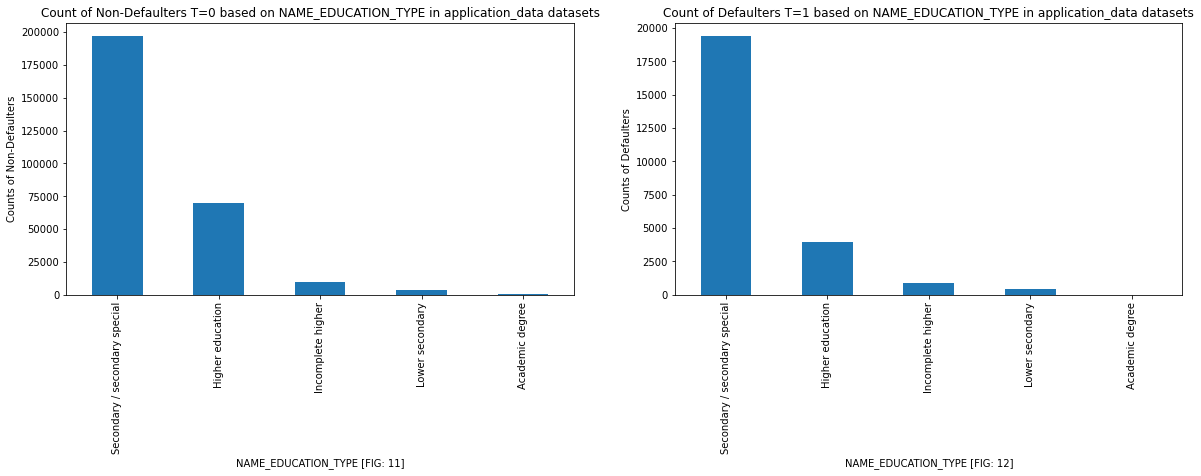

In [54]:
# Plotting the count and Level of highest education the client achieved ('NAME_EDUCATION_TYPE') for in application_data datasets for Target =  0 and 1
plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
ad_T_0['NAME_EDUCATION_TYPE'].value_counts().plot(kind='bar')
plt.title("Count of Non-Defaulters T=0 based on NAME_EDUCATION_TYPE in application_data datasets")
plt.xlabel("NAME_EDUCATION_TYPE [FIG: 11]")
plt.ylabel('Counts of Non-Defaulters')

plt.subplot(1,2,2)
ad_T_1['NAME_EDUCATION_TYPE'].value_counts().plot(kind='bar')
plt.title("Count of Defaulters T=1 based on NAME_EDUCATION_TYPE in application_data datasets")
plt.xlabel("NAME_EDUCATION_TYPE [FIG: 12]")
plt.ylabel('Counts of Defaulters')
plt.show()

Analysis from above:

FIG:11, shows the pattern where maximum number of non-defaulters are having secondary level of education while applying for the loan

FIG:12, shows the pattern where maximum of the defaulters have secondary level of education while applying for the loan

##### Conclusion: We cannot decide much using NAME_EDUCATION_TYPE in identifying the defaulters, because both in the case of defaulters and non-defaulters the pattern followed is the same.

#### Univariate Analysis on selected ordered-categorical variables that are present in previous_application datasets
#### Univariate analysis on selected ordered-categorical variable ('NAME_CLIENT_TYPE') in previous application datasets for Target = 0 and 1

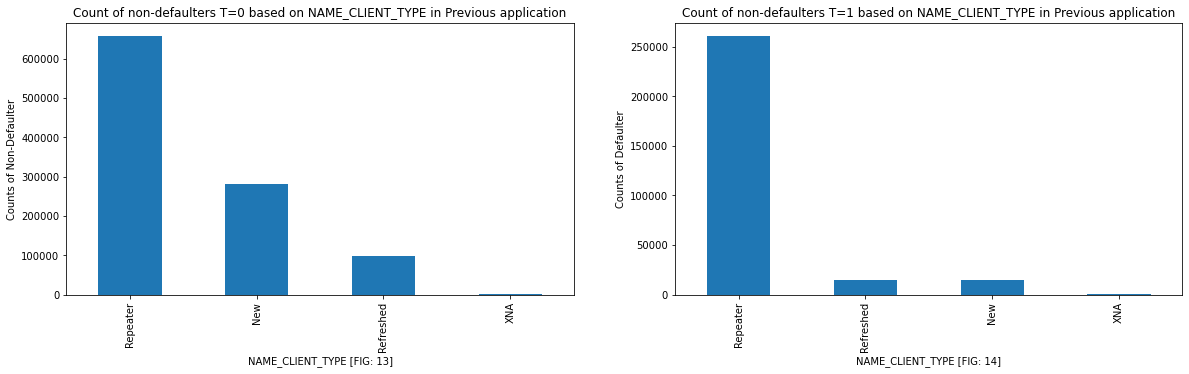

In [55]:
#Plotting the count and client type variable ('NAME_CLIENT_TYPE') for in previous application datasets for Target = 0 and 1

plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
pa_T_0['NAME_CLIENT_TYPE'].value_counts().plot(kind='bar')
plt.title('Count of non-defaulters T=0 based on NAME_CLIENT_TYPE in Previous application')
plt.xlabel('NAME_CLIENT_TYPE [FIG: 13]')
plt.ylabel('Counts of Non-Defaulter')

plt.subplot(1,2,2)
pa_T_1['NAME_CLIENT_TYPE'].value_counts().plot(kind='bar')
plt.title('Count of non-defaulters T=1 based on NAME_CLIENT_TYPE in Previous application')
plt.xlabel('NAME_CLIENT_TYPE [FIG: 14]')
plt.ylabel('Counts of Defaulter')
plt.show()

Analysis on above:

FIG:13, shows the pattern where maximum number of non-defaulters are also repeated customers while applying for the loan

FIG:14, shows the same pattern as above where maximum number of defaulters are also repeated customers while applying for the loan

##### Conclusion: We cannot decide much using NAME_Client_TYPE in identifying the defaulters, because both in the case of defaulters and non-defaulters the pattern followed is the same.

### 5.3.2 Univariate Analysis on selected unordered-categorical variables that are present in both datasets


#### Univariate analysis on selected unordered-categorical variable ('NAME_CONTRACT_TYPE') in both datasets for Target = 1

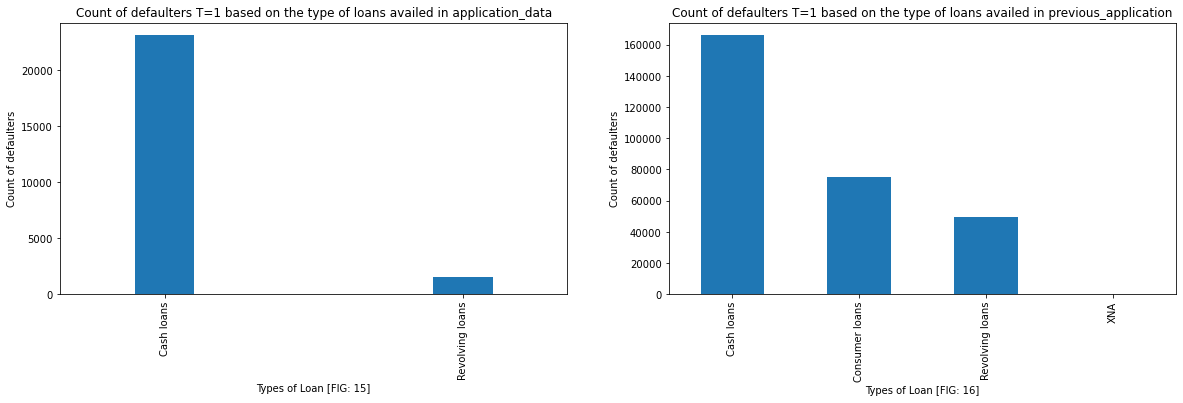

In [56]:
# Plotting the count and rank varaibles for NAME_CONTRACT_TYPE in both datasets for Target = 1

plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
ad_T_1['NAME_CONTRACT_TYPE'].value_counts().plot(kind='bar',width=0.2)
plt.title('Count of defaulters T=1 based on the type of loans availed in application_data')
plt.xlabel('Types of Loan [FIG: 15]')
plt.ylabel('Count of defaulters')

plt.subplot(122)
pa_T_1['NAME_CONTRACT_TYPE'].value_counts().plot(kind='bar')
plt.title('Count of defaulters T=1 based on the type of loans availed in previous_application')
plt.xlabel('Types of Loan [FIG: 16]')
plt.ylabel('Count of defaulters')

plt.show()

#### Univariate analysis on selected unordered-categorical variable ('NAME_CONTRACT_TYPE') in both datasets for Target = 0



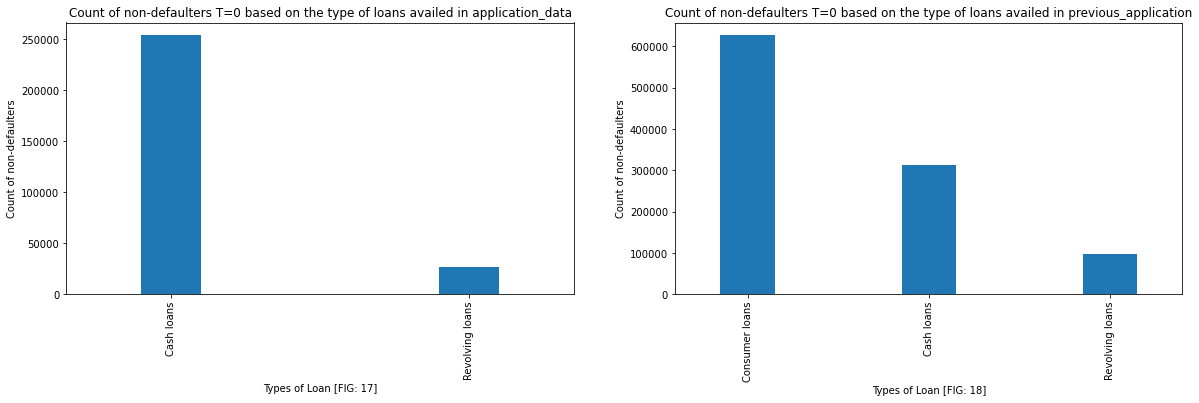

In [57]:
#Plotting the count and rank varaibles for WEEKDAY_APPR_PROCESS_START in both datasets for Target = 0
plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
ad_T_0['NAME_CONTRACT_TYPE'].value_counts().plot(kind='bar',width=0.2)
plt.title('Count of non-defaulters T=0 based on the type of loans availed in application_data')
plt.xlabel('Types of Loan [FIG: 17]')
plt.ylabel('Count of non-defaulters')

plt.subplot(1,2,2)
pa_T_0['NAME_CONTRACT_TYPE'].value_counts().plot(kind='bar',width=0.3)
plt.title('Count of non-defaulters T=0 based on the type of loans availed in previous_application')
plt.xlabel('Types of Loan [FIG: 18]')
plt.ylabel('Count of non-defaulters')

plt.show()

Analysis from above:

FIG:15&16, shows that the maximum of defaulters availed cash loans

FIG:17&18, shows the same pattern as above where maximum number of non-defaulters availed cash loan too.

##### Conclusion: We cannot decide much using type of loan availed in identifying the defaulters, because both in the case of defaulters and non-defaulters the pattern followed is the same.

### 5.3.3 Univariate Analysis on selected unordered-categorical variables that are present only in application_data datasets


#### Univariate analysis on selected unordered-categorical variable ('NAME_TYPE_SUITE') in application_data datasets for Target = 0 and 1

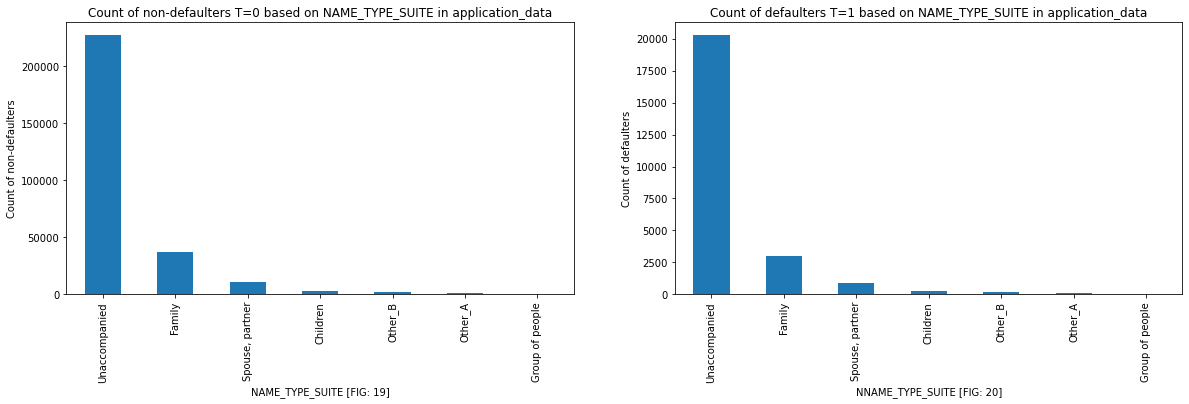

In [58]:
# Plotting the count and rank varaibles for NAME_TYPE_SUITE in application_data datasets for Target = 0 and 1
plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
ad_T_0.NAME_TYPE_SUITE.value_counts().plot(kind='bar')
plt.title("Count of non-defaulters T=0 based on NAME_TYPE_SUITE in application_data")
plt.xlabel("NAME_TYPE_SUITE [FIG: 19]")
plt.ylabel("Count of non-defaulters")

plt.subplot(1,2,2)
ad_T_1.NAME_TYPE_SUITE.value_counts().plot(kind='bar')
plt.title("Count of defaulters T=1 based on NAME_TYPE_SUITE in application_data")
plt.xlabel("NNAME_TYPE_SUITE [FIG: 20]")
plt.ylabel("Count of defaulters")
plt.show()

Analysis from above:

FIG:19, shows the pattern where maximum number of non-defaulters were unaccompanied too while applying for the loan

FIG:20, shows that the maximum of the defaulters were unaccompanied while applying for the loan

##### Conclusion: We cannot decide much using type of NAME_TYPE_SUITE in identifying the defaulters, because both in the case of defaulters and non-defaulters the pattern followed is the same.

#### Univariate analysis on selected unordered-categorical variable ('FLAG_OWN_CAR') in application_data datasets for Target = 0 and 1


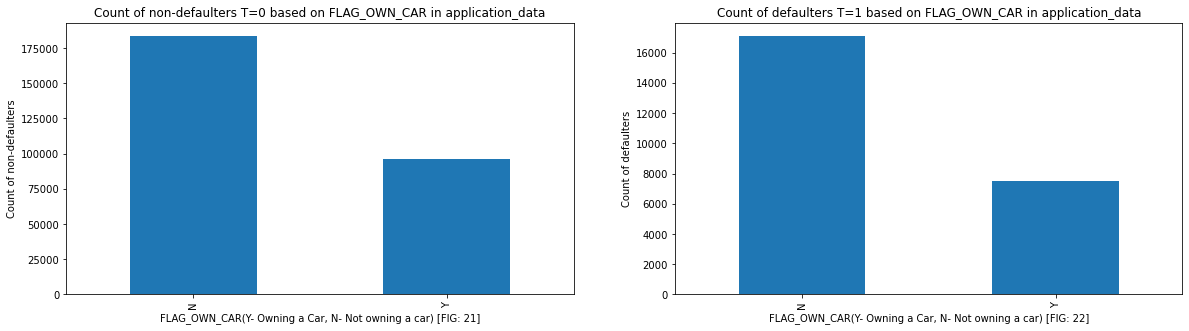

In [59]:
#Plotting the count and rank varaibles for FLAG_OWN_CAR in application_data datasets for Target = 0 and 1
plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
ad_T_0.FLAG_OWN_CAR.value_counts().plot(kind='bar')
plt.title("Count of non-defaulters T=0 based on FLAG_OWN_CAR in application_data")
plt.xlabel("FLAG_OWN_CAR(Y- Owning a Car, N- Not owning a car) [FIG: 21]")
plt.ylabel("Count of non-defaulters")

plt.subplot(1,2,2)
ad_T_1.FLAG_OWN_CAR.value_counts().plot(kind='bar')
plt.title("Count of defaulters T=1 based on FLAG_OWN_CAR in application_data")
plt.xlabel("FLAG_OWN_CAR(Y- Owning a Car, N- Not owning a car) [FIG: 22]")
plt.ylabel("Count of defaulters")
plt.show()

Analysis on above:

FIG:21, shows the pattern where maximum number of non-defaulters were not having car while applying for the loan
FIG:22, shows that the maximum of the defaulters are not having a car while applying for the loan

##### Conclusion: We cannot decide much using type of FLAG_OWN_CAR in identifying the defaulters, because both in the case of defaulters and non-defaulters the pattern followed is the same.

#### Univariate analysis on selected unordered-categorical variable ('Code_Gender') in application_data datasets for Target = 0 and 1


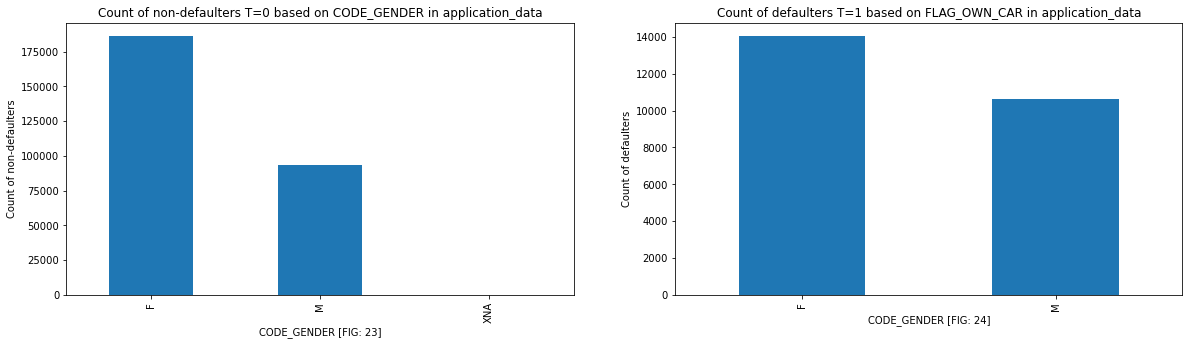

In [60]:
#Plotting the count and rank varaibles for CODE_GENDER in application_data datasets for Target = 0 and 1
plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
ad_T_0.CODE_GENDER.value_counts().plot(kind='bar')
plt.title("Count of non-defaulters T=0 based on CODE_GENDER in application_data")
plt.xlabel("CODE_GENDER [FIG: 23]")
plt.ylabel("Count of non-defaulters")

plt.subplot(1,2,2)
ad_T_1.CODE_GENDER.value_counts().plot(kind='bar')
plt.title("Count of defaulters T=1 based on FLAG_OWN_CAR in application_data")
plt.xlabel("CODE_GENDER [FIG: 24]")
plt.ylabel("Count of defaulters")
plt.show()

Analysis from above:

FIG:23, shows the pattern where maximum number of non-defaulters are Female
FIG:24, shows that the maximum of the defaulters are Female

##### Conclusion: We cannot decide much using Gender in identifying the defaulters, because both in the case of defaulters and non-defaulters the pattern followed is the same.

#### Univariate analysis on selected unordered-categorical variable ('FLAG_OWN_REALTY') in application_data datasets for Target = 0 amd 1

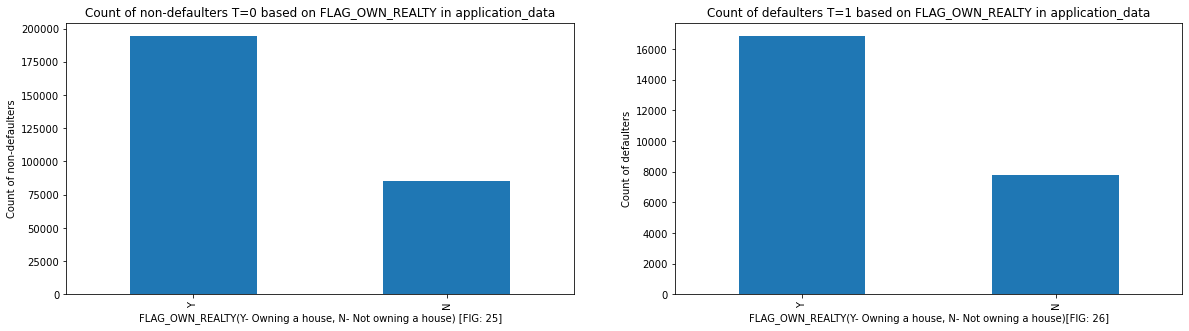

In [61]:
# Plotting the count and rank varaibles for FLAG_OWN_REALTY in application_data datasets for Target = 0 and 1

plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
ad_T_0.FLAG_OWN_REALTY.value_counts().plot(kind='bar')
plt.title("Count of non-defaulters T=0 based on FLAG_OWN_REALTY in application_data")
plt.xlabel("FLAG_OWN_REALTY(Y- Owning a house, N- Not owning a house) [FIG: 25]")
plt.ylabel("Count of non-defaulters")

plt.subplot(1,2,2)
ad_T_1.FLAG_OWN_REALTY.value_counts().plot(kind='bar')
plt.title("Count of defaulters T=1 based on FLAG_OWN_REALTY in application_data")
plt.xlabel("FLAG_OWN_REALTY(Y- Owning a house, N- Not owning a house)[FIG: 26]")
plt.ylabel("Count of defaulters")
plt.show()

Analysis from above:

FIG:25, shows pattern  where maximum number of non-defaulters are owning a house/flat

FIG:26, shows that the maximum of the defaulters are owning a house/flat

##### Conclusion: We cannot decide much on owning a house/Flat in identifying the defaulters, because both in the case of defaulters and non-defaulters the pattern followed is the same.

#### Univariate analysis on selected unordered-categorical variable 'NAME_INCOME_TYPE' in application_data datasets for Target = 0 and 1

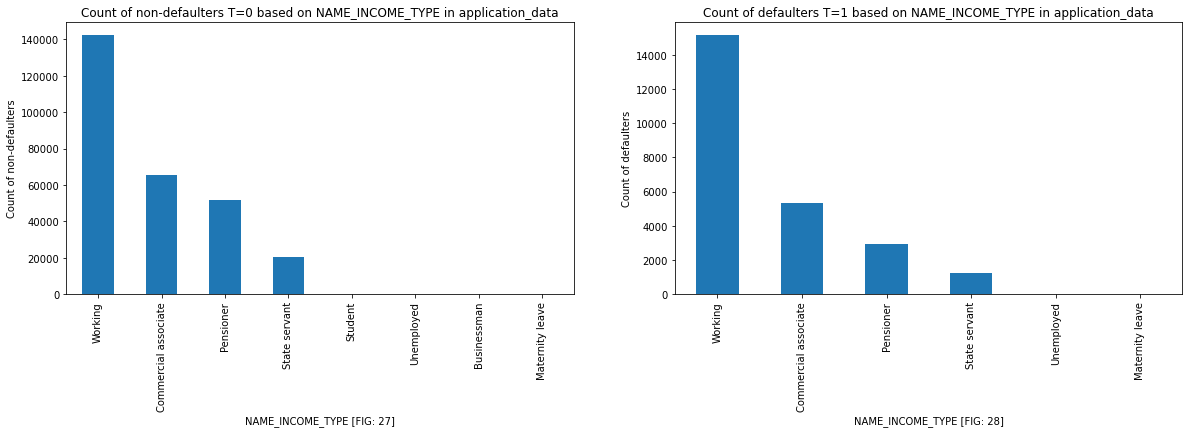

In [62]:
# Plotting the count and rank varaibles for NAME_INCOME_TYPE in application_data datasets for Target = 0 and 1

plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
ad_T_0.NAME_INCOME_TYPE.value_counts().plot(kind='bar')
plt.title("Count of non-defaulters T=0 based on NAME_INCOME_TYPE in application_data")
plt.xlabel("NAME_INCOME_TYPE [FIG: 27]")
plt.ylabel("Count of non-defaulters")

plt.subplot(1,2,2)
ad_T_1.NAME_INCOME_TYPE.value_counts().plot(kind='bar')
plt.title("Count of defaulters T=1 based on NAME_INCOME_TYPE in application_data")
plt.xlabel("NAME_INCOME_TYPE [FIG: 28]")
plt.ylabel("Count of defaulters")
plt.show()

Analysis from 3.8.5:

FIG:27, shows the pattern where maximum number of non-defaulters are working people

FIG:21, shows that the maximum number of defaulters are working people

##### Conclusion: We cannot decide much on NAME_INCOME_TYPE because both in the case of defaulters and non-defaulters the pattern followed is the same.

#### Univariate analysis on selected unordered-categorical variable ('NAME_FAMILY_STATUS') in application_data datasets for Target = 0 and 1

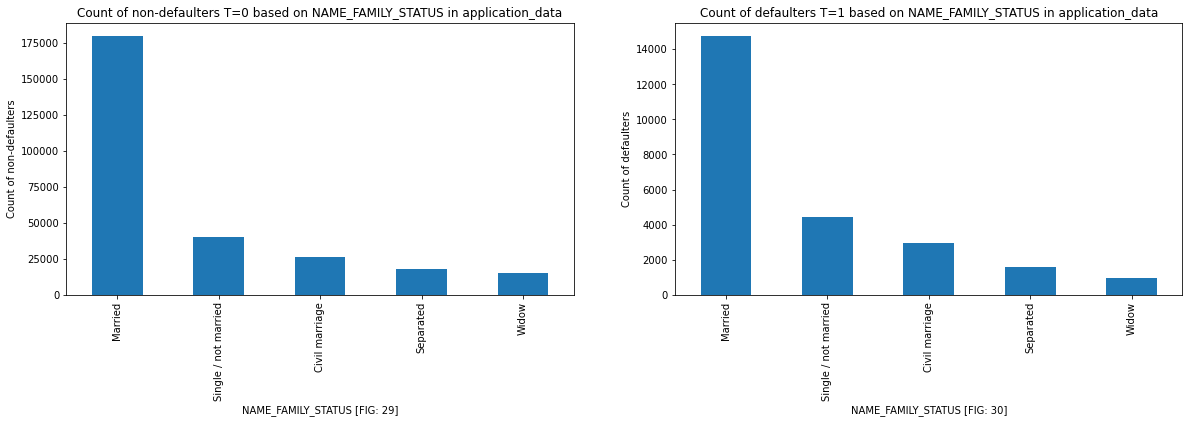

In [63]:
# Plotting the count and rank varaibles for NAME_FAMILY_STATUS in application_data datasets for Target = 0 and 1

plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
ad_T_0.NAME_FAMILY_STATUS.value_counts().plot(kind='bar')
plt.title("Count of non-defaulters T=0 based on NAME_FAMILY_STATUS in application_data")
plt.xlabel("NAME_FAMILY_STATUS [FIG: 29]")
plt.ylabel("Count of non-defaulters")

plt.subplot(1,2,2)
ad_T_1.NAME_FAMILY_STATUS.value_counts().plot(kind='bar')
plt.title("Count of defaulters T=1 based on NAME_FAMILY_STATUS in application_data")
plt.xlabel("NAME_FAMILY_STATUS [FIG: 30]")
plt.ylabel("Count of defaulters")
plt.show()

Analysis from 3above:

FIG:29, shows the pattern where maximum number of non-defaulters are Married people

FIG:30, shows that the maximum of the defaulters are Married people

##### Conclusion: We cannot decide much on NAME_FAMILY_STATUS because both in the case of defaulters and non-defaulters the pattern followed is the same.

#### Univariate analysis on selected unordered-categorical variable ('NAME_HOUSING_TYPE') in application_data datasets for Target = 0 and 1

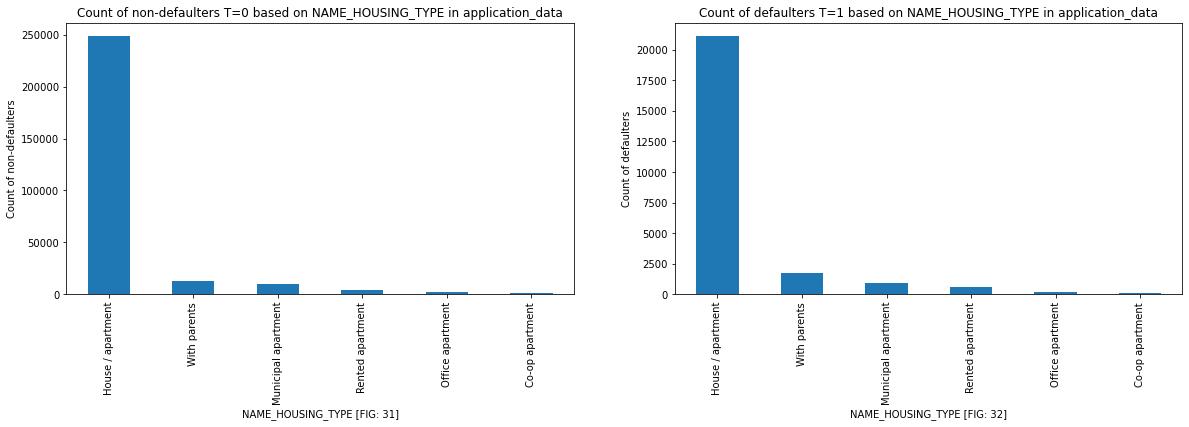

In [64]:
# Plotting the count and rank varaibles for NAME_HOUSING_TYPE in application_data datasets for Target = 0 and 1

plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
ad_T_0.NAME_HOUSING_TYPE.value_counts().plot(kind='bar')
plt.title("Count of non-defaulters T=0 based on NAME_HOUSING_TYPE in application_data")
plt.xlabel("NAME_HOUSING_TYPE [FIG: 31]")
plt.ylabel("Count of non-defaulters")

plt.subplot(1,2,2)
ad_T_1.NAME_HOUSING_TYPE.value_counts().plot(kind='bar')
plt.title("Count of defaulters T=1 based on NAME_HOUSING_TYPE in application_data")
plt.xlabel("NAME_HOUSING_TYPE [FIG: 32]")
plt.ylabel("Count of defaulters")
plt.show()


Analysis from above:

FIG:31, shows the pattern where maximum number of non-defaulters are living in house/appartment
    
FIG:32, shows that the maximum of the defaulters are living in house/appartment

###### Conclusion: We cannot decide much on NAME_HOUSING_TYPE because both in the case of defaulters and non-defaulters the pattern followed is the same.

### 5.3.4 Univariate Analysis on selected unordered-categorical variables that are present only in previous_application datasets

#### Univariate analysis on selected unordered-categorical variable ('PRODUCT_COMBINATION') in previous_application datasets for Target = 0 and 1

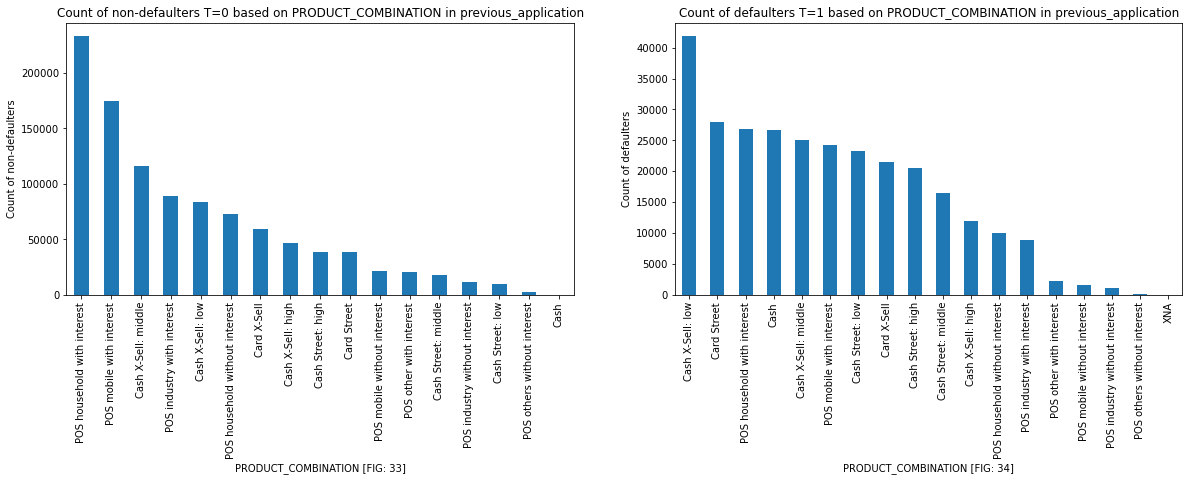

In [65]:
# Plotting the count and rank varaibles for PRODUCT_COMBINATION in previous_application datasets for Target = 0 and 1

plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
pa_T_0.PRODUCT_COMBINATION.value_counts().plot(kind='bar')
plt.title('Count of non-defaulters T=0 based on PRODUCT_COMBINATION in previous_application')
plt.xlabel('PRODUCT_COMBINATION [FIG: 33]')
plt.ylabel('Count of non-defaulters')

plt.subplot(1,2,2)
pa_T_1.PRODUCT_COMBINATION.value_counts().plot(kind='bar')
plt.title('Count of defaulters T=1 based on PRODUCT_COMBINATION in previous_application')
plt.xlabel('PRODUCT_COMBINATION [FIG: 34]')
plt.ylabel('Count of defaulters')
plt.show()

Analysis from above:

FIG:33, shows that the maximum of non-defaulters are in category 'POS household with interest'
    
FIG:34, shows that the maximum of the defaulters are in category 'cash X-sell: low'

###### Conclusion: We can frame a pattern by using the variable 'PRODUCT_COMBINATION'. That is, if the product_combination is 'cash X-sell: low' the person who applies for the loan might become a defaulter. In other hand, if the product_combination is 'POS household with interest'the person who applies for the loan might become a non-defaulter. By knowing this we can approve the loan for the non-defaulters and reject for people who tend to be defaulters.

#### Univariate analysis on selected unordered-categorical variable ('NAME_YIELD_GROUP') in previous_application datasets for Target = 0 and 1

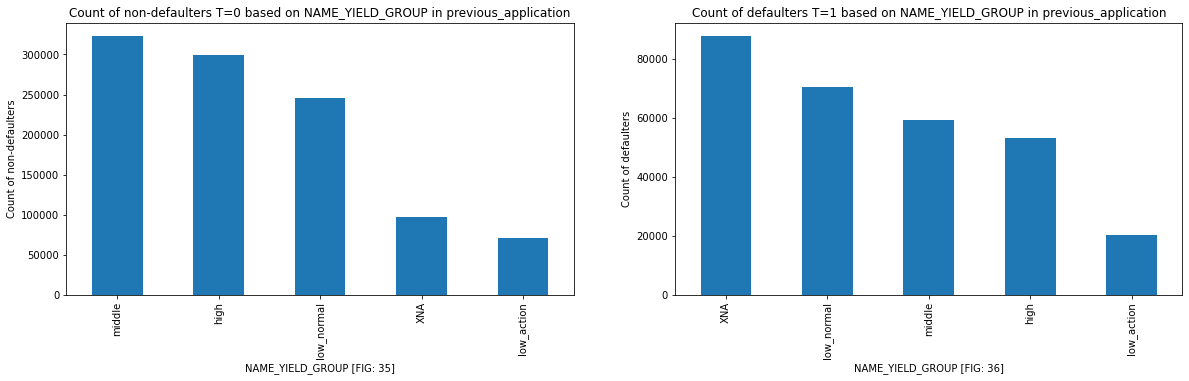

In [66]:
# Plotting the count and rank varaibles for NAME_YIELD_GROUP in previous_application datasets for Target = 1&0

plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
pa_T_0.NAME_YIELD_GROUP.value_counts().plot(kind='bar')
plt.title('Count of non-defaulters T=0 based on NAME_YIELD_GROUP in previous_application')
plt.xlabel('NAME_YIELD_GROUP [FIG: 35]')
plt.ylabel('Count of non-defaulters')

plt.subplot(1,2,2)
pa_T_1.NAME_YIELD_GROUP.value_counts().plot(kind='bar')
plt.title('Count of defaulters T=1 based on NAME_YIELD_GROUP in previous_application')
plt.xlabel('NAME_YIELD_GROUP [FIG: 36]')
plt.ylabel('Count of defaulters')
plt.show()

Analysis from above:

FIG:35, shows that the maximum of non-defaulters are in category 'middle'
    
FIG:36, shows that the maximum of the defaulters are in category 'XNA'

##### Conclusion: We can frame a pattern by using the variable 'NAME_YIELD_GROUP'. That is, if the NAME_YIELD_GROUP is 'XNA' the person who applies for the loan might become a defaulter. In other hand, if the NAME_YIELD_GROUP is 'middle' the person who applies for the loan might become a non-defaulter. By knowing this we can approve the loan for the non-defaulters and reject for people who tend to be defaulters.

#### Univariate analysis on selected unordered-categorical variable ('CHANNEL_TYPE') in previous_application datasets for Target = 0 and 1

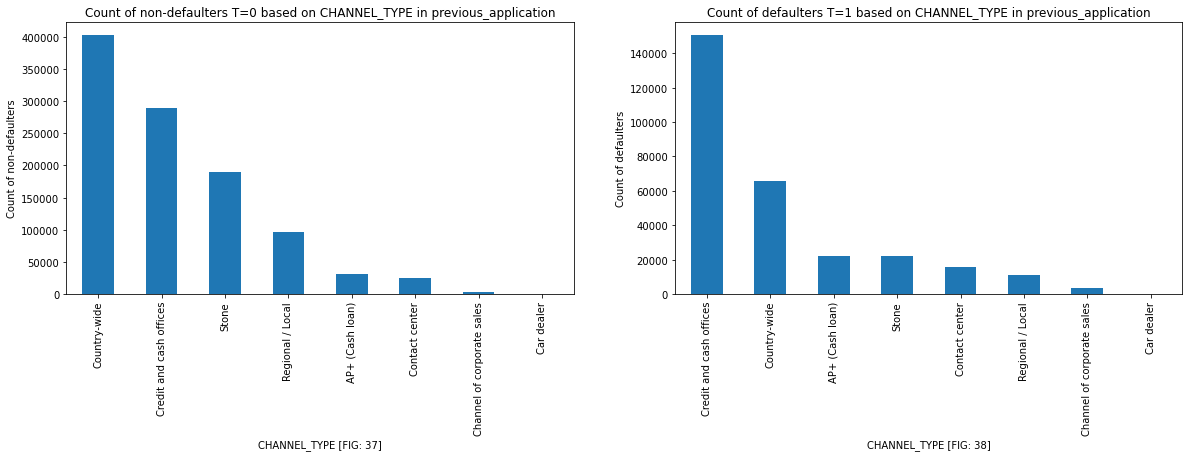

In [67]:
# Plotting the count and rank varaibles for CHANNEL_TYPE in previous_application datasets for Target = 0 and 1
plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
pa_T_0.CHANNEL_TYPE.value_counts().plot(kind='bar')
plt.title('Count of non-defaulters T=0 based on CHANNEL_TYPE in previous_application')
plt.xlabel('CHANNEL_TYPE [FIG: 37]')
plt.ylabel('Count of non-defaulters')

plt.subplot(1,2,2)
pa_T_1.CHANNEL_TYPE.value_counts().plot(kind='bar')
plt.title('Count of defaulters T=1 based on CHANNEL_TYPE in previous_application')
plt.xlabel('CHANNEL_TYPE [FIG: 38]')
plt.ylabel('Count of defaulters')
plt.show()

Analysis from above:

FIG:37, shows that the maximum of non-defaulters are in category 'country-wide'
    
FIG:38, shows that the maximum of the defaulters are in category 'Credit and cash offices'

##### Conclusion: We can frame a pattern by using the variable 'CHANNEL_TYPE'. That is, if the CHANNEL_TYPE is 'Credit and cash offices' the person who applies for the loan might become a defaulter. In other hand, if the CHANNEL_TYPE is ''country-wide'' the person who applies for the loan might become a non-defaulter. By knowing this we can approve the loan for the non-defaulters and reject for people who tend to be defaulters.

#### Univariate analysis on selected unordered-categorical variable ('NAME_PORTFOLIO') in previous_application datasets for Target = 0 and 1

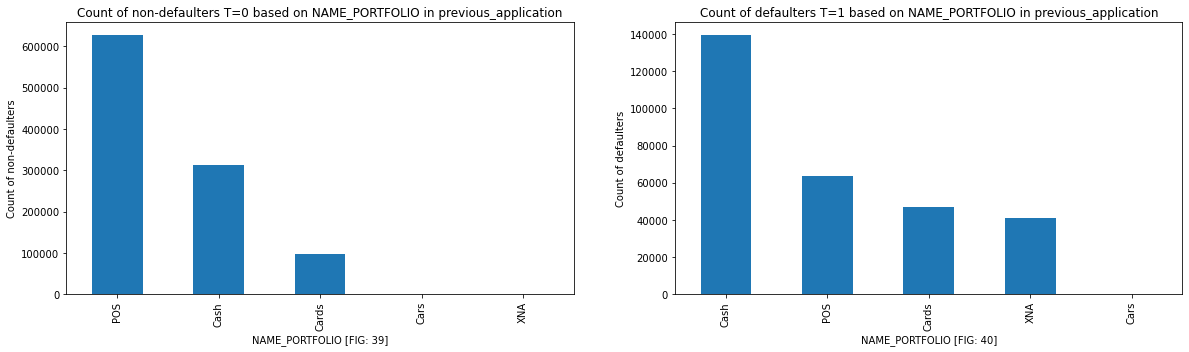

In [68]:
#Plotting the count and rank varaibles for NAME_PORTFOLIO in previous_application datasets for Target = 0 and 1

plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
pa_T_0.NAME_PORTFOLIO.value_counts().plot(kind='bar')
plt.title('Count of non-defaulters T=0 based on NAME_PORTFOLIO in previous_application')
plt.xlabel('NAME_PORTFOLIO [FIG: 39]')
plt.ylabel('Count of non-defaulters')

plt.subplot(1,2,2)
pa_T_1.NAME_PORTFOLIO.value_counts().plot(kind='bar')
plt.title('Count of defaulters T=1 based on NAME_PORTFOLIO in previous_application')
plt.xlabel('NAME_PORTFOLIO [FIG: 40]')
plt.ylabel('Count of defaulters')
plt.show()

Analysis from above:

FIG:39, shows that the maximum of non-defaulters are in category 'POS'
    
FIG:40, shows that the maximum of the defaulters are in category 'Cash'

##### Conclusion: We can frame a pattern by using the variable 'NAME_PORTFOLIO'. That is, if the NAME_PORTFOLIO is 'Cash' the person who applies for the loan might become a defaulter.  In other hand, if the NAME_PORTFOLIO is 'POS' the person who applies for the loan might become a non-defaulter. By knowing this we can approve the loan for the non-defaulters and reject for people who tend to be defaulters

### 5.3.5 Univariate Analysis on Numerical variables that are common in both datasets for target 0 and 1:


#### Univariate Analysis on Numerical variables (AMT_CREDIT) that are common in both datasets with target = 0 and 1

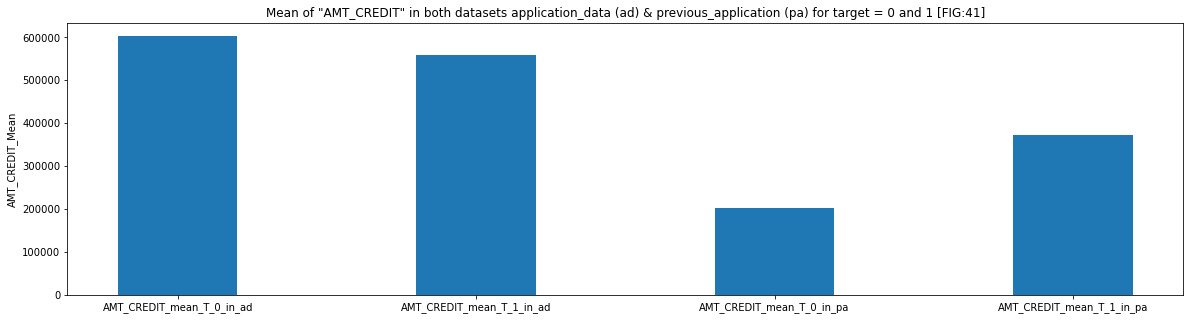

In [69]:
## Plotting the Mean for varible AMT_CREDIT in both datasets for Target = 0 and 1

mean_ad_T_0=ad_T_0['AMT_CREDIT'].mean()
mean_ad_T_1=ad_T_1['AMT_CREDIT'].mean()
mean_pa_T_0=pa_T_0['AMT_CREDIT'].mean()
mean_pa_T_1=pa_T_1['AMT_CREDIT'].mean()

x = ['AMT_CREDIT_mean_T_0_in_ad','AMT_CREDIT_mean_T_1_in_ad','AMT_CREDIT_mean_T_0_in_pa','AMT_CREDIT_mean_T_1_in_pa']
y = [mean_ad_T_0,mean_ad_T_1,mean_pa_T_0,mean_pa_T_1]

plt.figure(figsize=[20,5])
plt.bar(x,y,width=0.4)
plt.title('Mean of "AMT_CREDIT" in both datasets application_data (ad) & previous_application (pa) for target = 0 and 1 [FIG:41]')
plt.ylabel('AMT_CREDIT_Mean')
plt.show()

Analysis from above:

FIG:41, shows that in general (mean) the value of AMT_CREDIT is high for defaulters T=1 in both the data sets (pa & ad).
##### Conclusion: We have to extra careful in providing loan with applicats holding more AMT_CREDIT because they may most likely to become a defaulter

###  5.3.6 Segmented Univariate Analysis on Numerical variables in application_data datasets:


#### Segmented Univariate Analysis on Numerical variable (AMT_INCOME_TOTAL) in application_data datasets for Target 1&0 on the basis of Gender

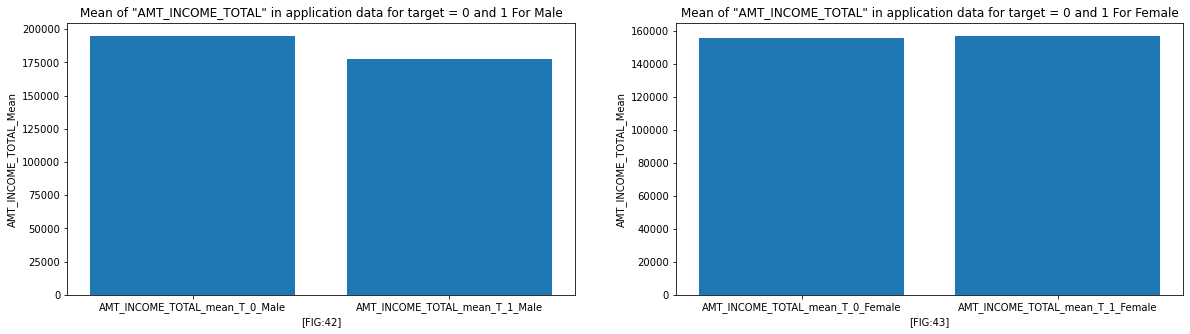

In [70]:
# Plotting the Mean for varible AMT_INCOME_TOTAL in application dataset for Target = 0 and 1 on the basis of Gender in application_data dataset
mean_ad_T_0_M=ad_T_0[ad_T_0.CODE_GENDER=='M']['AMT_INCOME_TOTAL'].mean()
mean_ad_T_0_F=ad_T_0[ad_T_0.CODE_GENDER=='F']['AMT_INCOME_TOTAL'].mean()
mean_ad_T_1_M=ad_T_1[ad_T_1.CODE_GENDER=='M']['AMT_INCOME_TOTAL'].mean()
mean_ad_T_1_F=ad_T_1[ad_T_1.CODE_GENDER=='F']['AMT_INCOME_TOTAL'].mean()

x_male = ['AMT_INCOME_TOTAL_mean_T_0_Male','AMT_INCOME_TOTAL_mean_T_1_Male']
y_male = [mean_ad_T_0_M,mean_ad_T_1_M]

x_female = ['AMT_INCOME_TOTAL_mean_T_0_Female','AMT_INCOME_TOTAL_mean_T_1_Female']
y_female = [mean_ad_T_0_F,mean_ad_T_1_F]

plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
plt.bar(x_male,y_male)
plt.title('Mean of "AMT_INCOME_TOTAL" in application data for target = 0 and 1 For Male')
plt.xlabel('[FIG:42]')
plt.ylabel('AMT_INCOME_TOTAL_Mean')

plt.subplot(122)
plt.bar(x_female,y_female)
plt.title('Mean of "AMT_INCOME_TOTAL" in application data for target = 0 and 1 For Female')
plt.xlabel('[FIG:43]')
plt.ylabel('AMT_INCOME_TOTAL_Mean')

plt.show()


Analysis from above:

FIG:42, shows that in general (mean) among male the defaulters (T-1) do have less income compared to non-defaulters (T-0).

FIG:43, shows that in general (mean) among Female the defaulters (T-1) do have less income compared to non-defaulters (T-0).

##### Conclusion: We have to extra careful in providing loan for applications holding less income since they may most likely to become defaulters.

#### Segmented Univariate Analysis on Numerical variable (AMT_ANNUITY) in application_data datasets for Target 1&0 on the basis of Gender

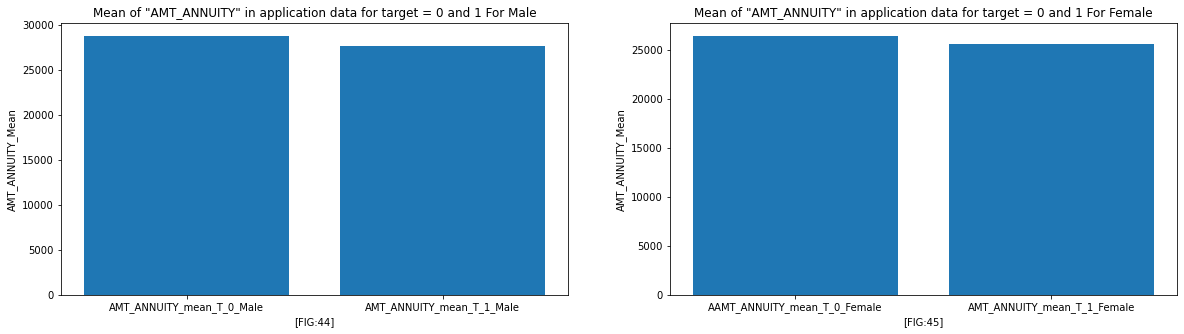

In [71]:
# Plotting the Mean for varible AMT_ANNUITY in application dataset for Target = 1&0 on the basis of Gender in application_data dataset

mean_ad_T_0_M=ad_T_0[ad_T_0.CODE_GENDER=='M']['AMT_ANNUITY'].mean()
mean_ad_T_0_F=ad_T_0[ad_T_0.CODE_GENDER=='F']['AMT_ANNUITY'].mean()
mean_ad_T_1_M=ad_T_1[ad_T_1.CODE_GENDER=='M']['AMT_ANNUITY'].mean()
mean_ad_T_1_F=ad_T_1[ad_T_1.CODE_GENDER=='F']['AMT_ANNUITY'].mean()

x_male = ['AMT_ANNUITY_mean_T_0_Male','AMT_ANNUITY_mean_T_1_Male']
y_male = [mean_ad_T_0_M,mean_ad_T_1_M]

x_female = ['AAMT_ANNUITY_mean_T_0_Female','AMT_ANNUITY_mean_T_1_Female']
y_female = [mean_ad_T_0_F,mean_ad_T_1_F]

plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
plt.bar(x_male,y_male)
plt.title('Mean of "AMT_ANNUITY" in application data for target = 0 and 1 For Male')
plt.xlabel('[FIG:44]')
plt.ylabel('AMT_ANNUITY_Mean')

plt.subplot(122)
plt.bar(x_female,y_female)
plt.title('Mean of "AMT_ANNUITY" in application data for target = 0 and 1 For Female')
plt.xlabel('[FIG:45]')
plt.ylabel('AMT_ANNUITY_Mean')

plt.show()

Analysis from above:

FIG:44, shows that in general (mean) among male the defaulters T=1 do have less AMT_ANNUITY compared to non-defaulters (T-0).

FIG:45, shows that in general (mean) among Female the defaulters T=1 do have less AMT_ANNUITY compared to non-defaulters (T-0).

##### Conclusion: We have to extra careful in providing loan for applications holding less AMT_ANNUITY since they may most likely to become defaulters.

#### Segmented Univariate Analysis on Numerical variable (AMT_GOODS_PRICE) in application_data datasets for Target 1&0 on the basis of Gender


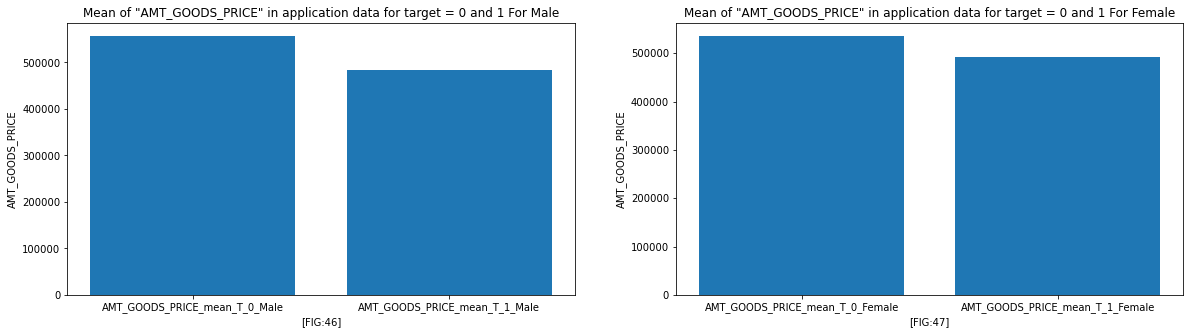

In [72]:
## Plotting the Mean for varible AMT_GOODS_PRICE in both datasets for Target = 1&0 on the basis of Gender in application_data dataset
mean_ad_T_0_M=ad_T_0[ad_T_0.CODE_GENDER=='M']['AMT_GOODS_PRICE'].mean()
mean_ad_T_0_F=ad_T_0[ad_T_0.CODE_GENDER=='F']['AMT_GOODS_PRICE'].mean()
mean_ad_T_1_M=ad_T_1[ad_T_1.CODE_GENDER=='M']['AMT_GOODS_PRICE'].mean()
mean_ad_T_1_F=ad_T_1[ad_T_1.CODE_GENDER=='F']['AMT_GOODS_PRICE'].mean()

x_male = ['AMT_GOODS_PRICE_mean_T_0_Male','AMT_GOODS_PRICE_mean_T_1_Male']
y_male = [mean_ad_T_0_M,mean_ad_T_1_M]

x_female = ['AMT_GOODS_PRICE_mean_T_0_Female','AMT_GOODS_PRICE_mean_T_1_Female']
y_female = [mean_ad_T_0_F,mean_ad_T_1_F]

plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
plt.bar(x_male,y_male)
plt.title('Mean of "AMT_GOODS_PRICE" in application data for target = 0 and 1 For Male')
plt.xlabel('[FIG:46]')
plt.ylabel('AMT_GOODS_PRICE')

plt.subplot(122)
plt.bar(x_female,y_female)
plt.title('Mean of "AMT_GOODS_PRICE" in application data for target = 0 and 1 For Female')
plt.xlabel('[FIG:47]')
plt.ylabel('AMT_GOODS_PRICE')

plt.show()

Analysis from above:

FIG:46, shows that in general (mean) among male the defaulters (T-1) do have less AMT_GOODS_PRICE compared to non-defaulters (T-0).

FIG:47, shows that in general (mean) among Female the defaulters (T-1) do have less AMT_GOODS_PRICE compared to non-defaulters (T-0).

##### Conclusion: We have to extra careful in providing loan for applications holding less AMT_GOODS_PRICE since they may most likely to become defaulters.

### 5.3.7 Univariate Analysis on Numerical variables in Previous_application datasets for target 0 and 1


#### Univariate Analysis on Numerical variable (AMT_APPLICATION) in previous_application with target = 0 and 1

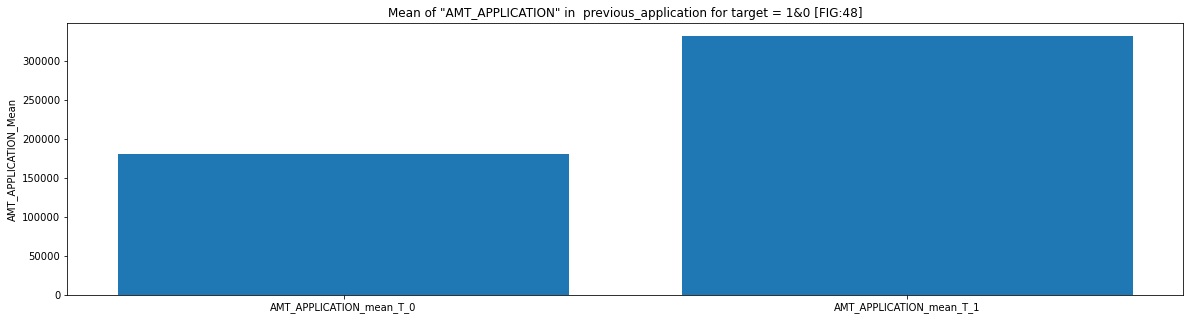

In [73]:
# Plotting the Mean for varible AMT_APPLICATION in previous_application with target = 0 and 1

mean_pa_T_0 = pa_T_0['AMT_APPLICATION'].mean()

mean_pa_T_1 = pa_T_1['AMT_APPLICATION'].mean()

x = ['AMT_APPLICATION_mean_T_0','AMT_APPLICATION_mean_T_1']

y = [mean_pa_T_0,mean_pa_T_1]


plt.figure(figsize=[20,5])
plt.bar(x,y)
plt.title('Mean of "AMT_APPLICATION" in  previous_application for target = 1&0 [FIG:48]')
plt.ylabel('AMT_APPLICATION_Mean')

plt.show()

Analysis from above:

FIG:48, shows that in general (mean) the defaulters (T-1) possess more in AMT_APPLICATION compared to non-defaulters (T-0).
    
##### Conclusion: We have to extra careful in providing loan for applications holding more AMT_APPLICATION since they may most likely to become defaulters.

## 6.2 More Univariate Analysis: Categorical Variables (AD)

#### In this section, we will test impact of various category variables against the TARGET variable.  Equal size samples are taken from both TARGET subsets.  If there is an impact of a categorical variable, then the bar plots should show a significantly unequal distribution for Target 0 and 1. 

In [74]:
# First, we create sets of related category variables of interest in Application data. 
# 'TARGET' variable has been added to each set of variables. 

personal_details = ['TARGET', 'CODE_GENDER','NAME_FAMILY_STATUS']
                    
career_and_income = ['TARGET', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'NAME_INCOME_TYPE', 'FLAG_OWN_CAR',
                    'FLAG_OWN_REALTY', 'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE']

contact_information = ['TARGET', 'FLAG_MOBIL','FLAG_EMP_PHONE','FLAG_WORK_PHONE',
                        'FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL']

documents_submitted = ['TARGET', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
                    'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
                    'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
                    'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
                    'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
                    'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
                    'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']

region_data = ['TARGET', 'REG_REGION_NOT_WORK_REGION','REG_REGION_NOT_LIVE_REGION',
                'REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY',
                'LIVE_REGION_NOT_WORK_REGION','LIVE_CITY_NOT_WORK_CITY']

application_processing = ['TARGET', 'NAME_CONTRACT_TYPE', 'NAME_TYPE_SUITE', 'WEEKDAY_APPR_PROCESS_START',
                    'HOUR_APPR_PROCESS_START']

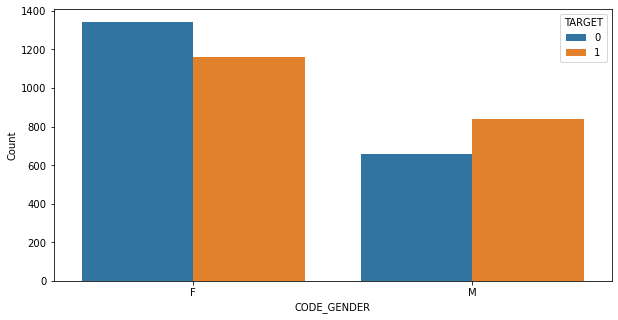

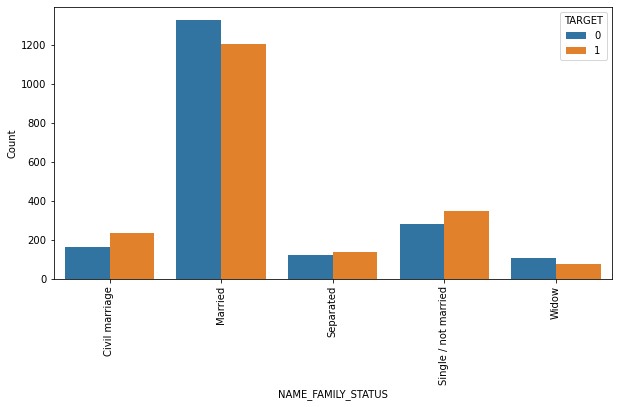

In [75]:
# Impact of personal details on TARGET. 

personal_details = ['TARGET', 'CODE_GENDER','NAME_FAMILY_STATUS']

# Sample data from the 2 targets (0 and 1)
df = GetSample(personal_details)

# Plot the category columns. 
MakeBarPlot_CategoryVars_vs_Target(df)

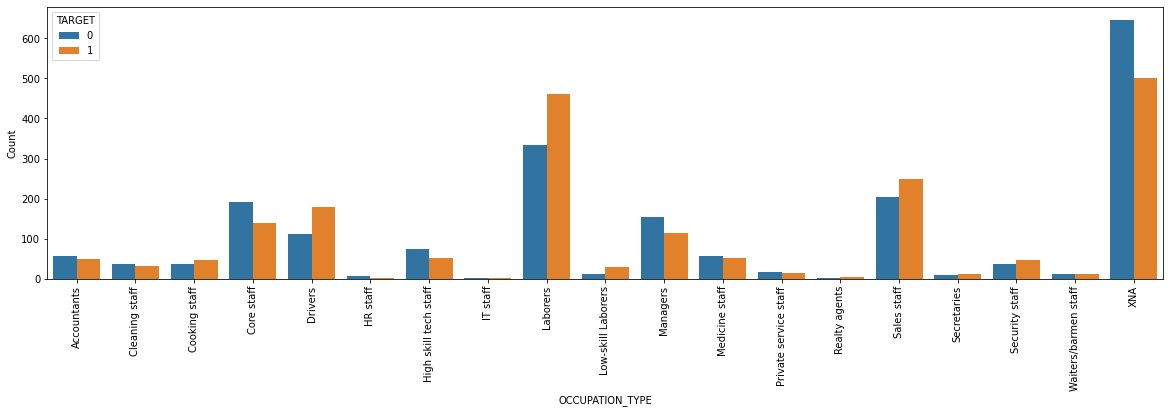

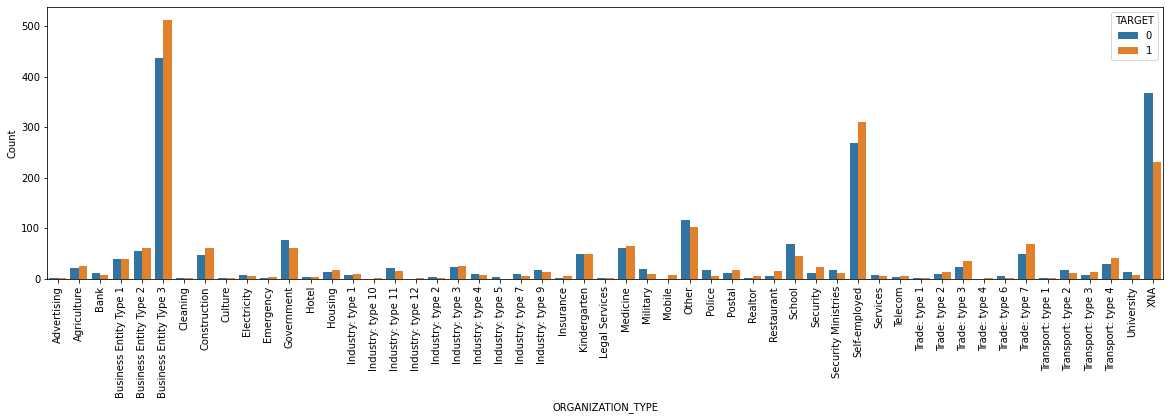

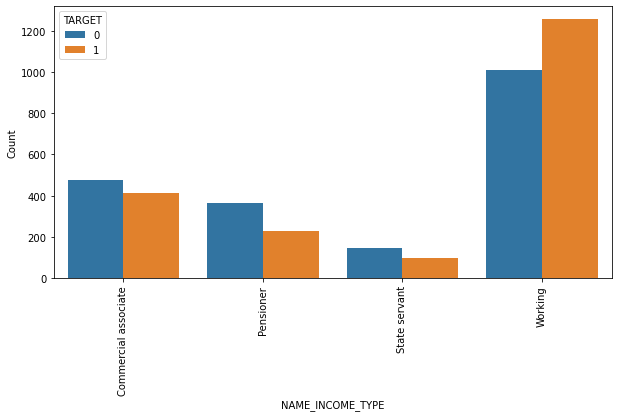

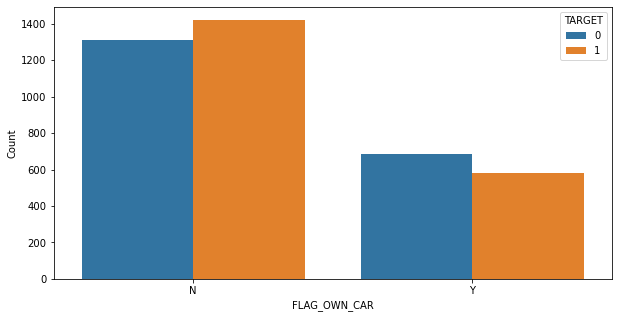

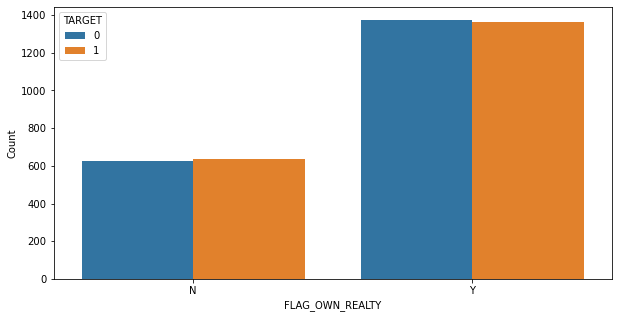

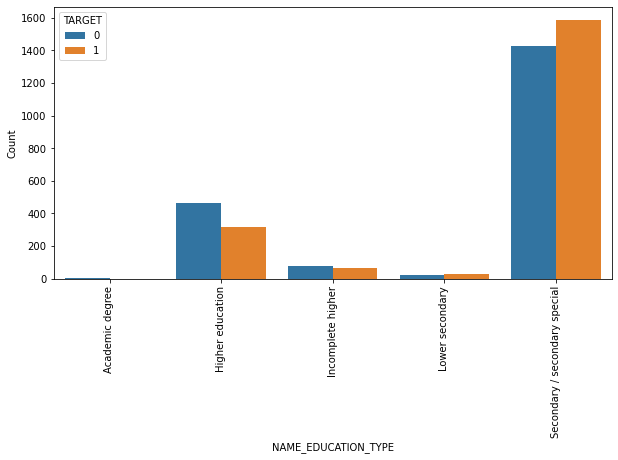

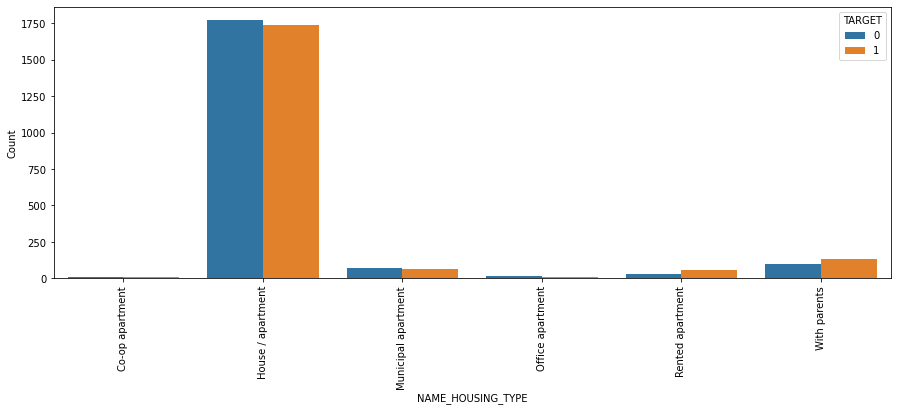

In [76]:
# Impact of fields related to clients career, income, assets etc. on TARGET. 
                    
career_and_income = ['TARGET', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'NAME_INCOME_TYPE', 'FLAG_OWN_CAR',
                    'FLAG_OWN_REALTY', 'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE']

# Sample data from the 2 targets (0 and 1)
df = GetSample(career_and_income)

# Plot the category columns. 
MakeBarPlot_CategoryVars_vs_Target(df)

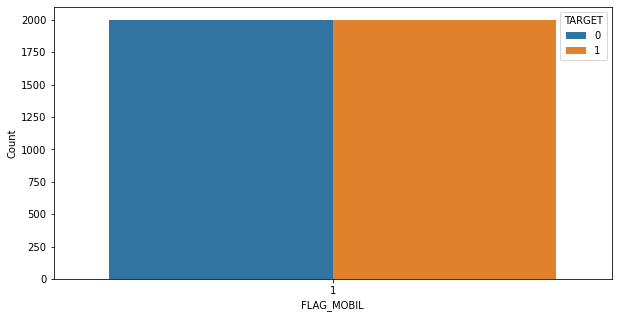

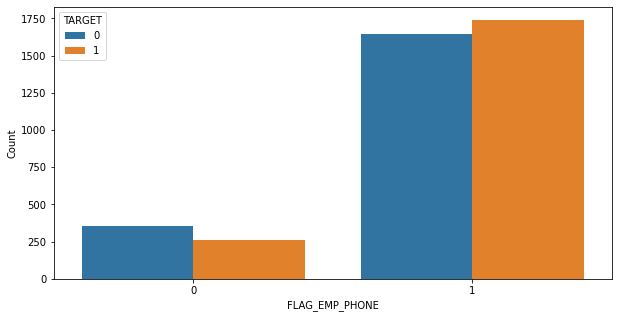

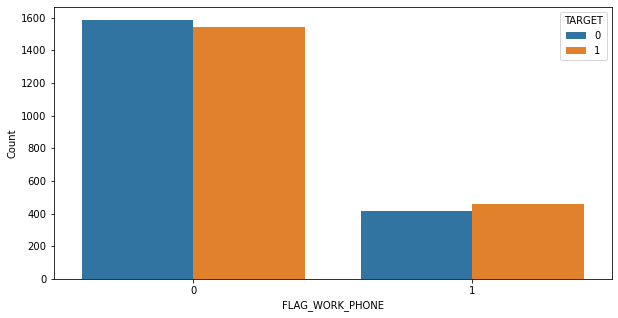

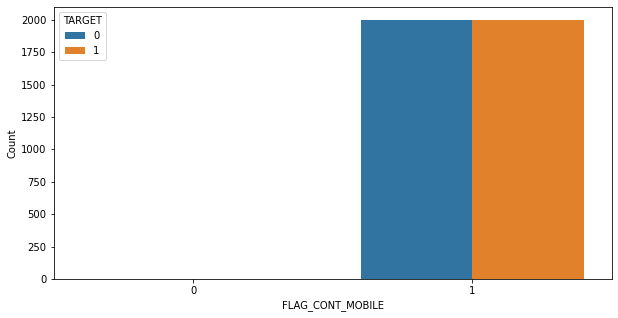

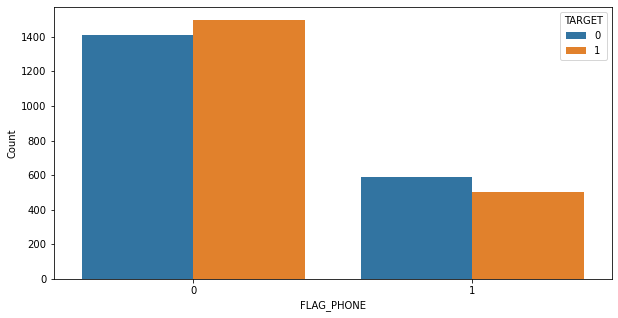

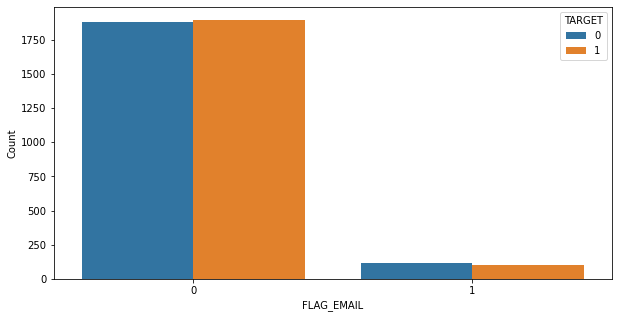

In [77]:
# Impact of fields for CONTACT INFORMATION on TARGET. 

contact_information = ['TARGET', 'FLAG_MOBIL','FLAG_EMP_PHONE','FLAG_WORK_PHONE',
                        'FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL']

# Sample data from the 2 targets (0 and 1)
df = GetSample(contact_information)

# Plot the category columns. 
MakeBarPlot_CategoryVars_vs_Target(df)

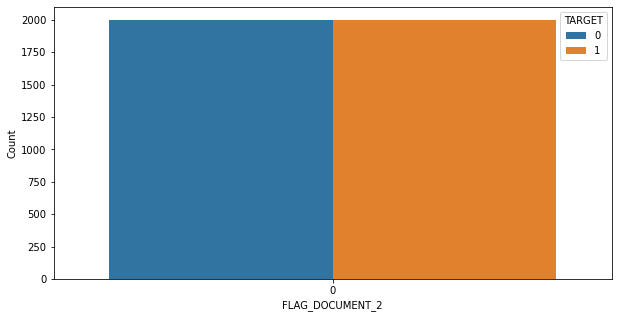

In [78]:
# Impact of fields related to Documentation Submitted on TARGET. 

# There are almost 20 FLAG_DOCUMENT_# fields.  Only one is included here as sample to prevent too many graphs. 
# However, it was seen that all 20 FLAG_DOCUMENT_# fields followed same pattern 
# (i.e., no distinction for T0 or T1 sets). 
documents_submitted = ['TARGET', 'FLAG_DOCUMENT_2']

# Sample data from the 2 targets (0 and 1)
df = GetSample(documents_submitted)

# Plot the category columns. 
MakeBarPlot_CategoryVars_vs_Target(df)

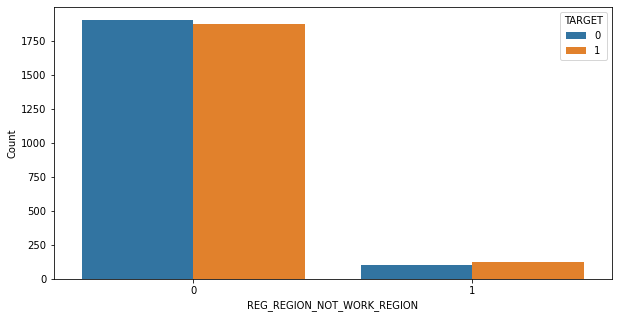

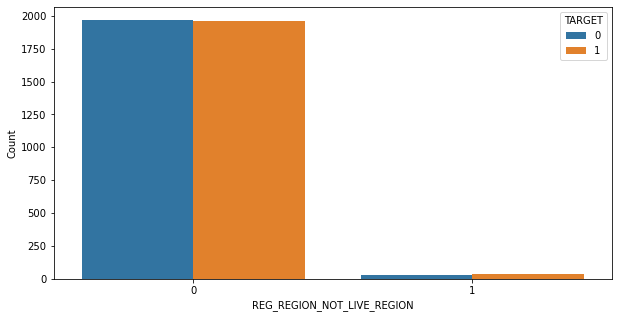

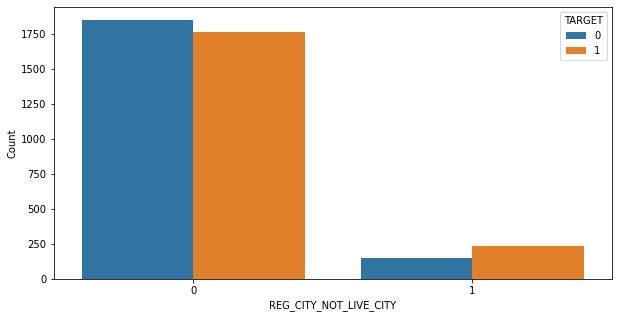

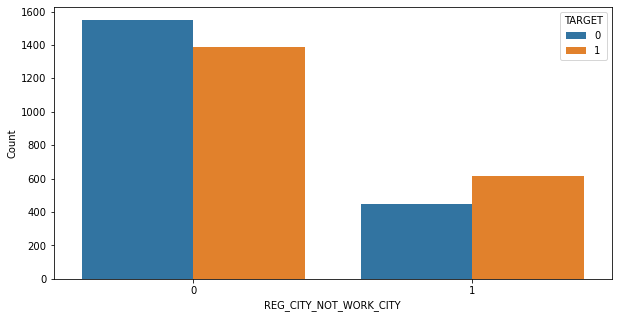

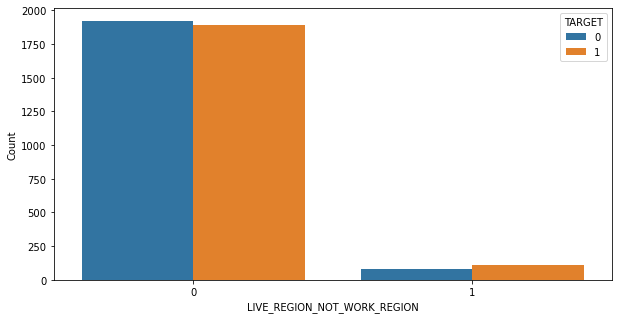

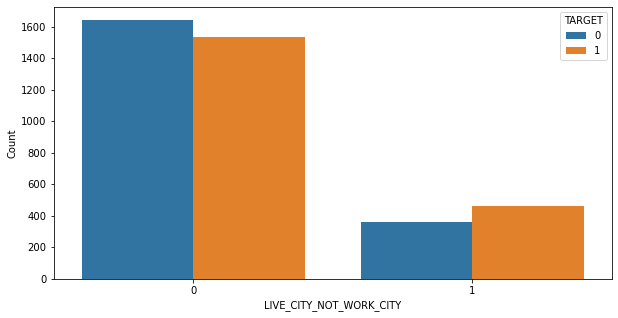

In [79]:
# Impact of fields related to REGION information on TARGETS 0 or 1. 

region_data = ['TARGET', 'REG_REGION_NOT_WORK_REGION','REG_REGION_NOT_LIVE_REGION',
                'REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY',
                'LIVE_REGION_NOT_WORK_REGION','LIVE_CITY_NOT_WORK_CITY']

# Sample data from the 2 targets (0 and 1)
df = GetSample(region_data)

# Plot the category columns. 
MakeBarPlot_CategoryVars_vs_Target(df)

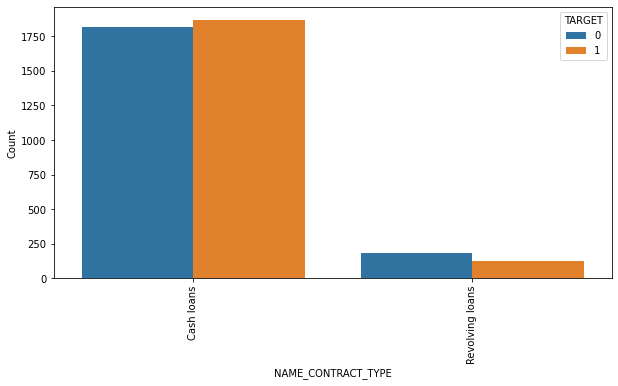

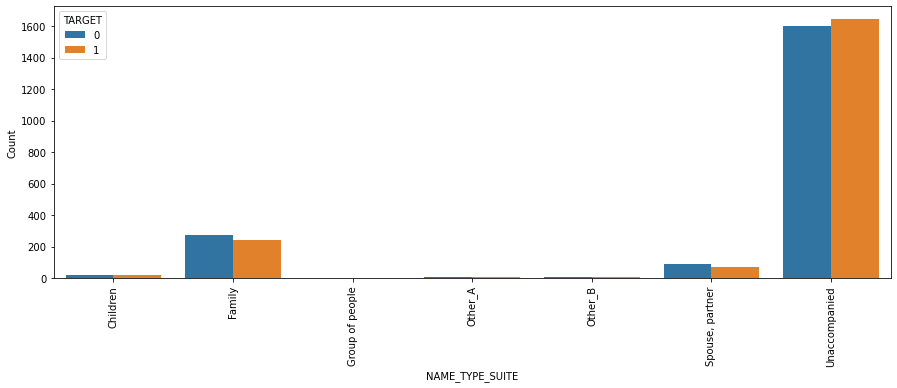

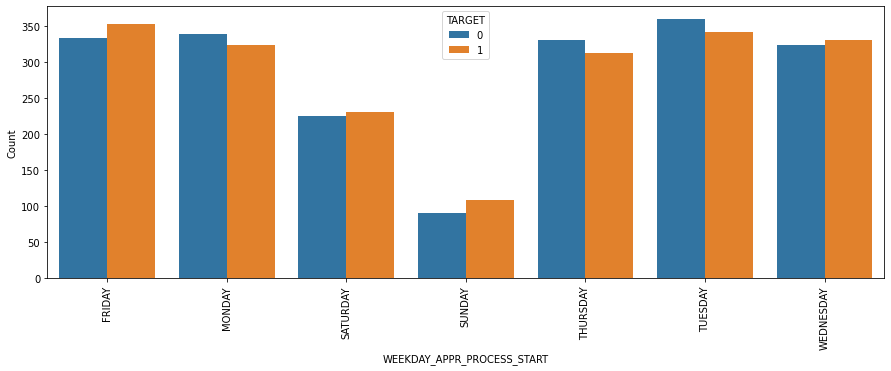

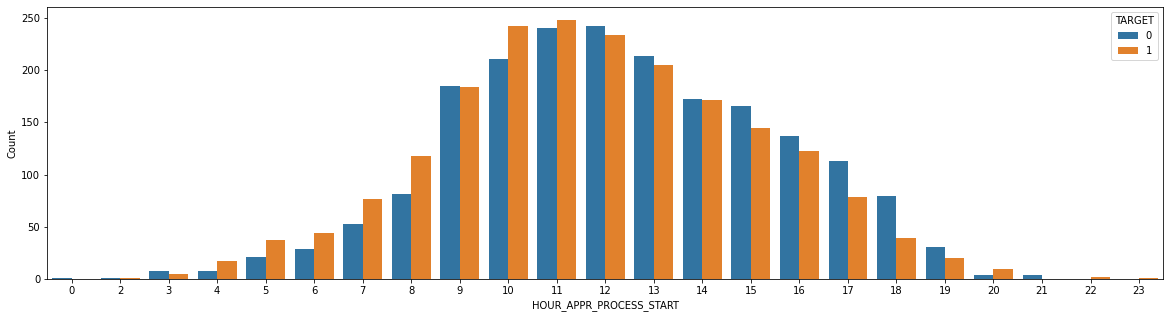

In [80]:
# Impact of fields related to conditions during application (such as who accompanied client, what time did client apply for ..etc) on TARGETS 0 or 1. 

application_processing = ['TARGET', 'NAME_CONTRACT_TYPE', 'NAME_TYPE_SUITE', 'WEEKDAY_APPR_PROCESS_START', 
                          'HOUR_APPR_PROCESS_START']

# Sample data from the 2 targets (0 and 1)
df = GetSample(application_processing)

# Plot the category columns. 
MakeBarPlot_CategoryVars_vs_Target(df)

# 7. DATA ANALYSIS - BiVariate Analysis

## 7.1 BiVariate Analysis: Non-Categorical Variables (AD)

In [81]:
# We also list the numerical variables of interest. We have divided the features into "related" features. 

num_personal = ['CNT_FAM_MEMBERS','CNT_CHILDREN', 'DAYS_BIRTH', 'DAYS_LAST_PHONE_CHANGE']
num_career_and_income = ['AMT_INCOME_TOTAL', 'DAYS_EMPLOYED', 'EDUCATION_SCORE' ]
num_region_extSources = ['REGION_POPULATION_RELATIVE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_3' ,
'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE' ]
num_application_processing = ['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_REGISTRATION','DAYS_ID_PUBLISH', ]

# Combine all the above columns
all_noncategory_cols = num_personal + num_career_and_income + num_region_extSources + num_application_processing


#### We take a look at the correlation between the numerical variables (of Application Data) using HEAT MAP. 

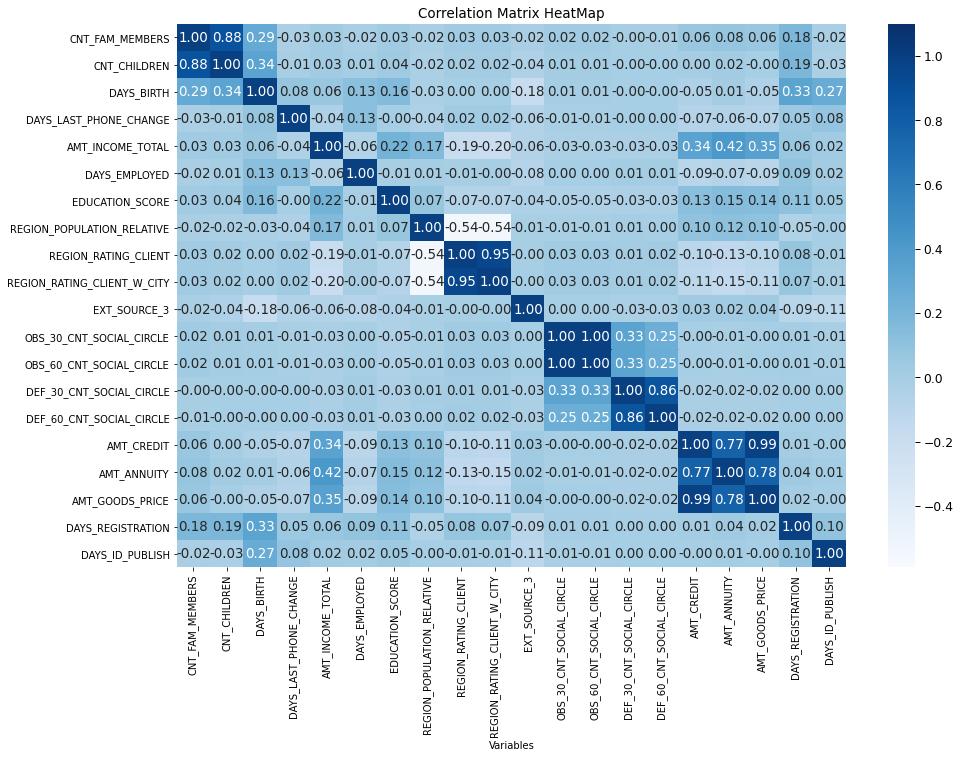

In [82]:
# Correlation in dataset for TARGET = 0 (No Default)
MakeHeatMap(ad_T_0, all_noncategory_cols)

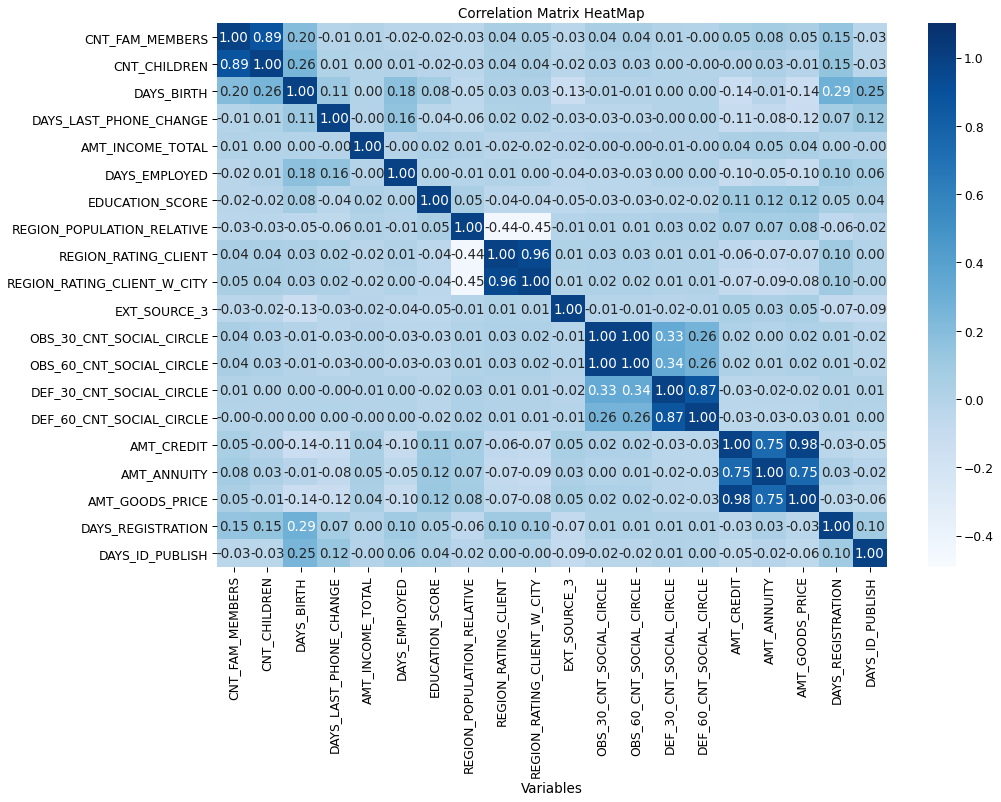

In [83]:
# Correlation in dataset for TARGET = 1 (Defaults)
MakeHeatMap(ad_T_1, all_noncategory_cols)

#### Observations: 
In both data sets (for Target_0 and Target_1) We see a strong correlation between:
- AMT_CREDIT
- AMT_ANNUITY
- AMT_GOODS_PRICE

This is to be expected, since AMT_CREDIT or ANNUITY extended to the client is based on the GOODS_PRICE.  However, we see one slight variation in that the Non-Defaulters INCOME_TOTAL has some (weak) correlation with these 3 variables. But the defaulters have no such correlation. This indicates that Non-Defaulters seem to seek Loans whose value correlate with their incomes; thereby strengthening the possibility of paying back the loans. The defaulters on the other hand seem to have gotten Loan amounts that do not correlate with their income (thus making the loans more risky)

### Distribution of the variables in Default-vs-NonDefault sets. 
The patterns between all other variables is the same for both datasets.  We should also look at the distribution of the variables in both sets. If a variable has impact on the TARGET, then its distribution in T0 and T1 sets would be different. 

In [84]:
Top10Correlations(ad_T_0)

                               V1                          V2  Correlation
1822     OBS_60_CNT_SOCIAL_CIRCLE    OBS_30_CNT_SOCIAL_CIRCLE     0.998513
340               AMT_GOODS_PRICE                  AMT_CREDIT     0.987260
1139  REGION_RATING_CLIENT_W_CITY        REGION_RATING_CLIENT     0.949905
1010              CNT_FAM_MEMBERS                CNT_CHILDREN     0.878681
1367  LIVE_REGION_NOT_WORK_REGION  REG_REGION_NOT_WORK_REGION     0.861303
1879     DEF_60_CNT_SOCIAL_CIRCLE    DEF_30_CNT_SOCIAL_CIRCLE     0.859458
1538      LIVE_CITY_NOT_WORK_CITY      REG_CITY_NOT_WORK_CITY     0.830488
341               AMT_GOODS_PRICE                 AMT_ANNUITY     0.775838
284                   AMT_ANNUITY                  AMT_CREDIT     0.770379
736                FLAG_EMP_PHONE                  DAYS_BIRTH     0.622090


In [85]:
Top10Correlations(ad_T_1)

                               V1                          V2  Correlation
1822     OBS_60_CNT_SOCIAL_CIRCLE    OBS_30_CNT_SOCIAL_CIRCLE     0.998286
340               AMT_GOODS_PRICE                  AMT_CREDIT     0.983065
1139  REGION_RATING_CLIENT_W_CITY        REGION_RATING_CLIENT     0.956477
1010              CNT_FAM_MEMBERS                CNT_CHILDREN     0.885556
1879     DEF_60_CNT_SOCIAL_CIRCLE    DEF_30_CNT_SOCIAL_CIRCLE     0.869761
1367  LIVE_REGION_NOT_WORK_REGION  REG_REGION_NOT_WORK_REGION     0.847260
1538      LIVE_CITY_NOT_WORK_CITY      REG_CITY_NOT_WORK_CITY     0.778110
341               AMT_GOODS_PRICE                 AMT_ANNUITY     0.752206
284                   AMT_ANNUITY                  AMT_CREDIT     0.751400
2197              FLAG_DOCUMENT_6              FLAG_EMP_PHONE     0.617071


#### Observations: 
- The top 10 correlations for pairs of variables (non-categorical) in application data show the same trends. 

<Figure size 720x720 with 0 Axes>

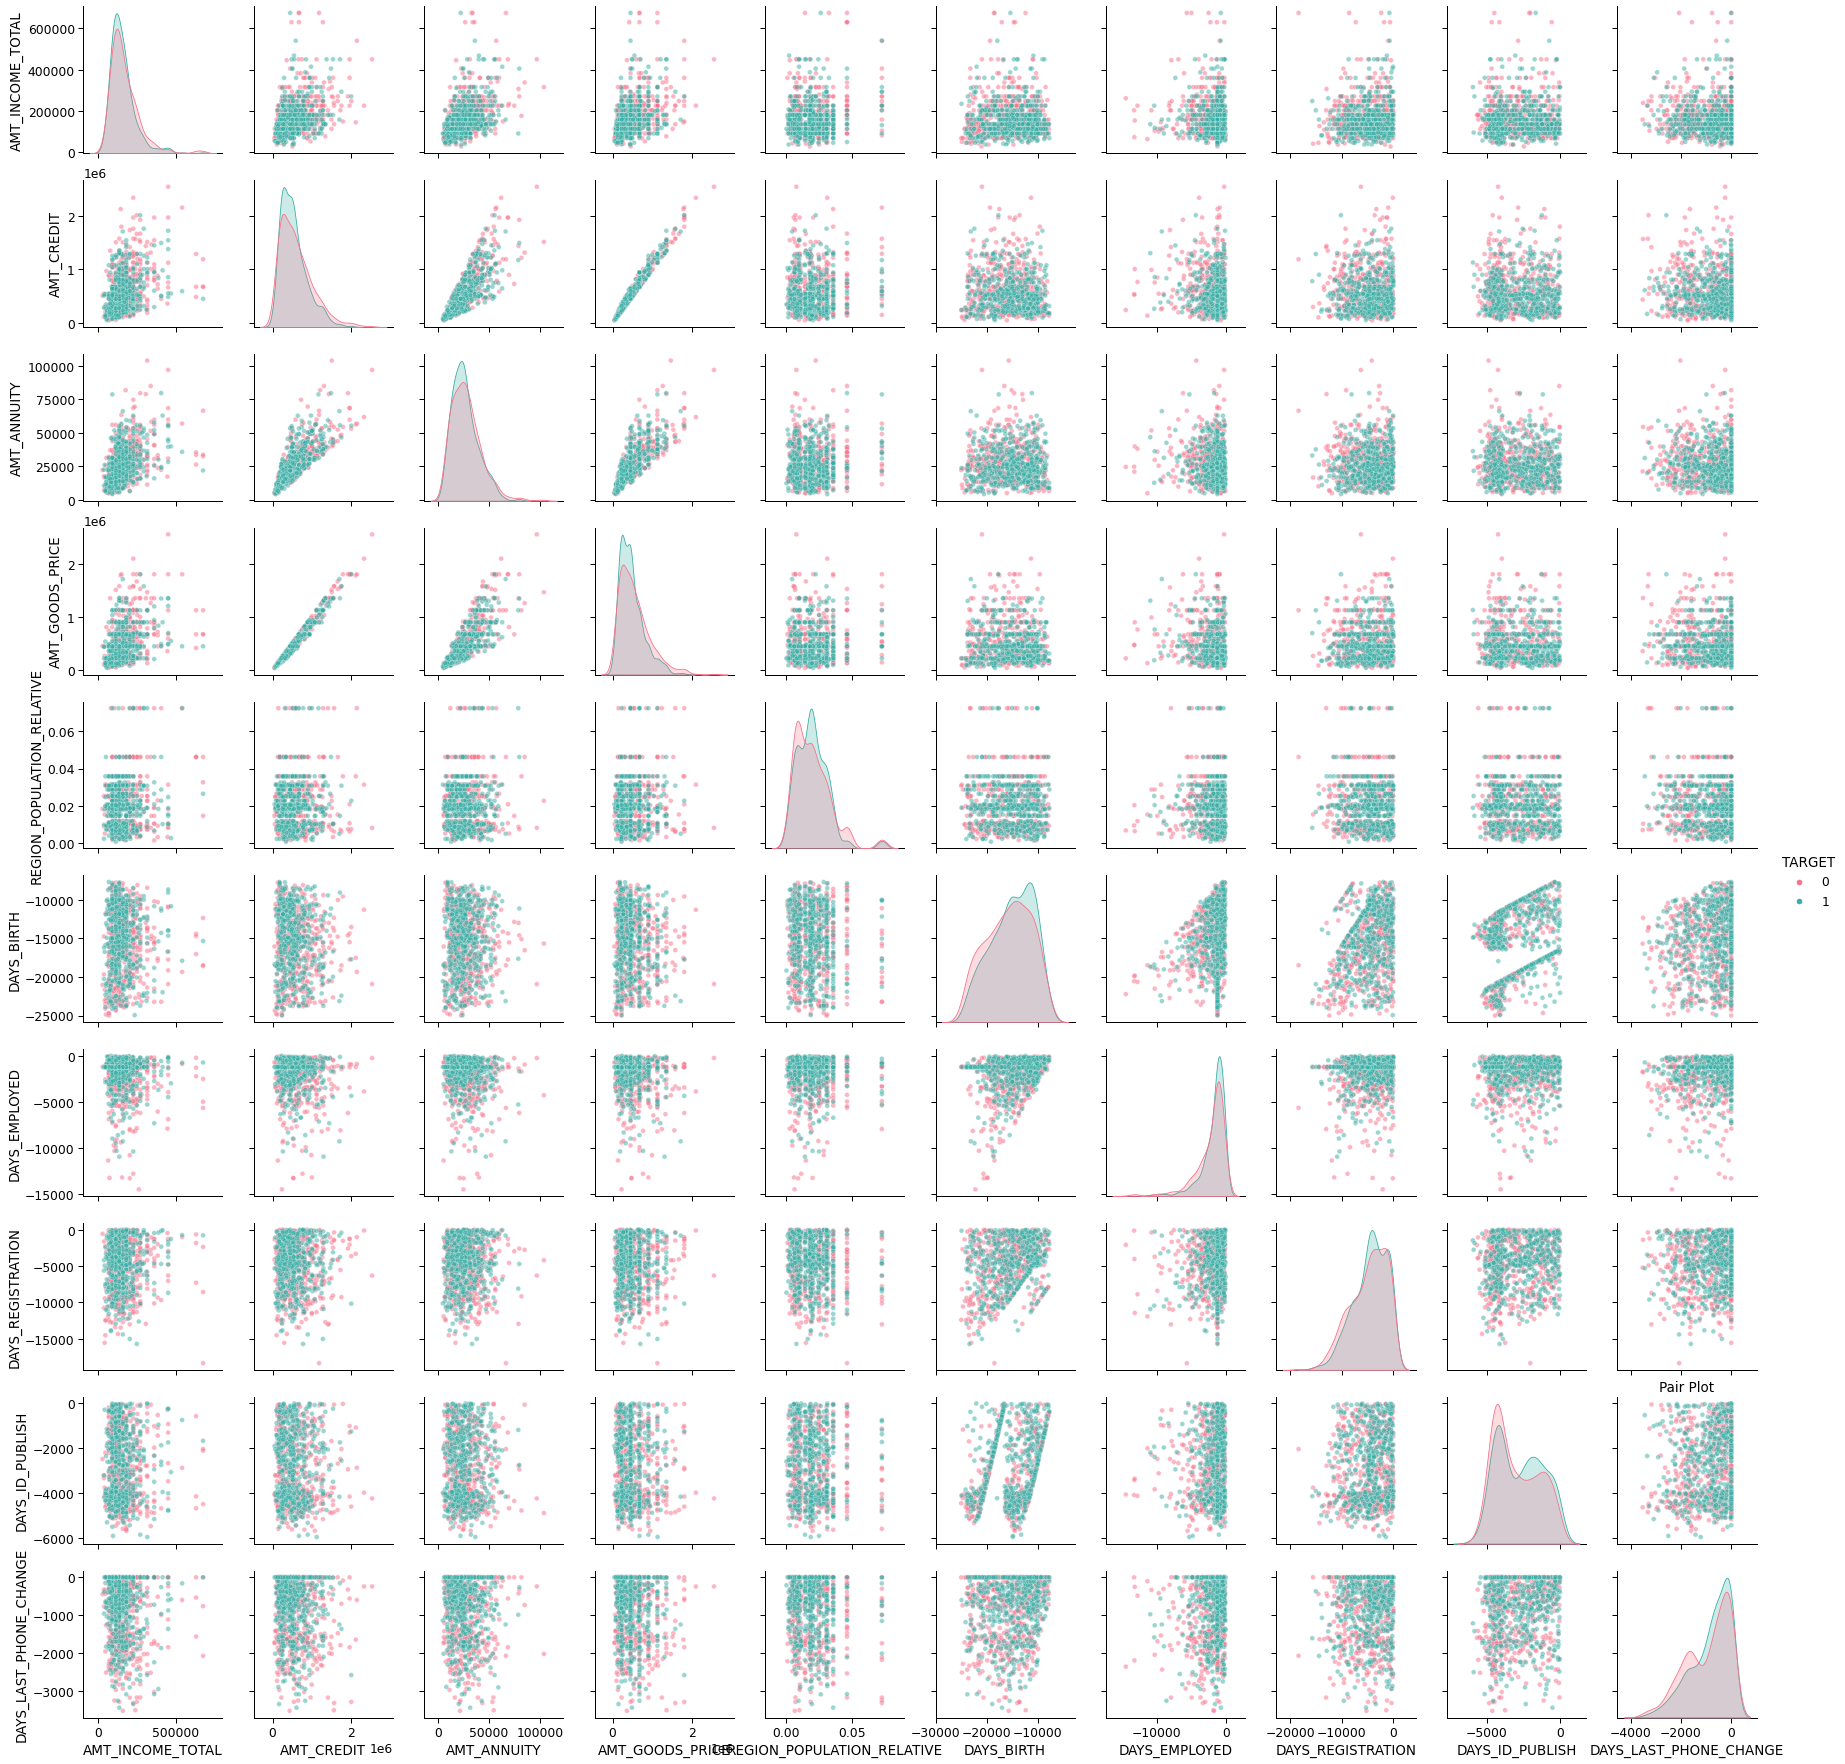

In [86]:
# We want to create PAIR-PLOTS of various numerical coumns in AD and view the distribution by TARGET variable. 
# For this, we will sample both ad_T_0 and ad_T_1 equally and create a combined dataframe. 

AD_NUM_COLS = ['TARGET', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 
                'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 
                'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE']

# We will collect a random sample of 1000 rows (500 each from ad_T_0 and ad_T_1)
df1 = ad_T_0[AD_NUM_COLS].sample(n=500, replace=False)
df2 = ad_T_1[AD_NUM_COLS].sample(n=500, replace=False)
df = pd.concat([df1, df2], axis=0)

 # PAIR PLOT
plt.figure(figsize=(10,10))
sns.pairplot(df, hue='TARGET', palette='husl', plot_kws={"alpha":0.5})
plt.title("Pair Plot")
plt.show()

### Observations:
Looking at the KDE plots (on the diagonal), we see that the distribution of the variables for both TARGET 0 and TARGET 1 are nearly identical. Hence, none of these variables (ALONE) can be used to predict if client is likely to be a defaulter. We can also confirm this for pretty much any numerical variable above using boxplots that give a clearer picture.

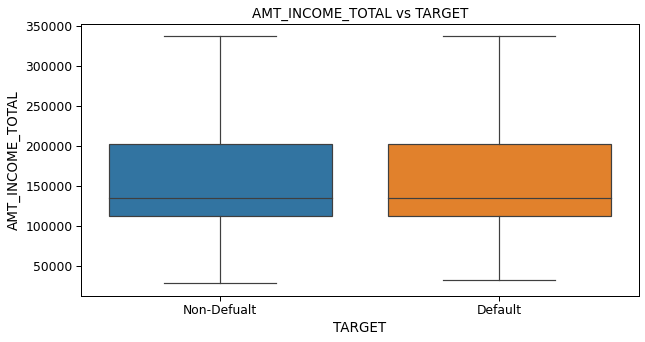

In [87]:
 
# Only one example of AMT_INCOME_TOTAL vs TARGET is shown below (2000 samples from each TARGET category). 
df = GetSample(AD_NUM_COLS)

plt.figure(figsize=(10,5))
ax = sns.boxplot(data=df, x='TARGET', y='AMT_INCOME_TOTAL', showfliers = False)
ax.set_xticklabels(['Non-Defualt', 'Default'])
plt.title("AMT_INCOME_TOTAL vs TARGET")
plt.show()

# Plot below shows a near identical distribution of income for both defaulters and non-defaulters. 
# This same pattern is observed for all other numerical varaibles as well (but not plotted here in
# interest of it becoming too many graphs). 

## 7.2 BiVariate Analysis: Categorical Variables (AD)

### In this section, we plot combinations of pairs of variables and their contribution to the target variable.  We will consider the following possible pairs: 

The permutations of all possible category variables would be very large. We narrow down the number of plots based on some intuition of what are some likely factors in defaulting on loans.  We consider the following variables: 

'CODE_GENDER', 'NAME_FAMILY_STATUS', 'OCCUPATION_TYPE', 'NAME_INCOME_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE', 'NAME_CONTRACT_TYPE'

Based on above fields, we will do a few of the following comparisons: 
- Family Status vs Gender
- Occupation type vs Gender
- Occupation type vs Loan Contract type
- Education Type vs Family Status
- Education Type vs Loan Contract Type
- Housing Type vs Owning a car
- Occupation Type vs Owning Realty


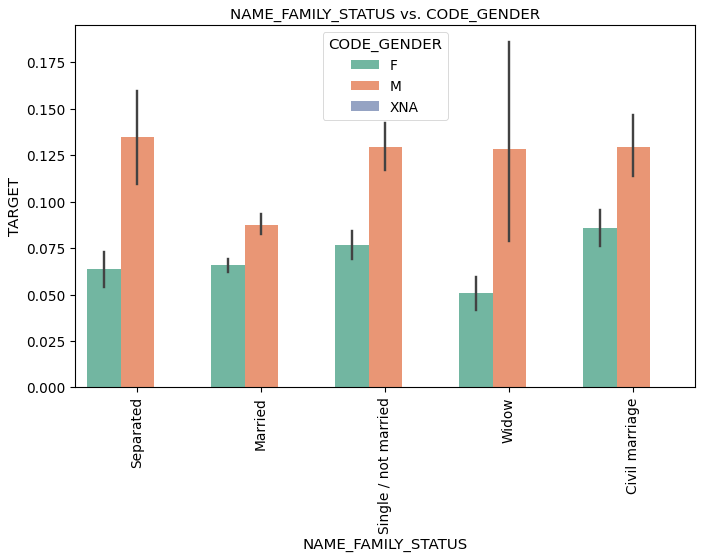

In [88]:
# Family Status vs Gender
BiVariateCategoryPlot(ad, 'NAME_FAMILY_STATUS', 'CODE_GENDER', 90)

### Observations
- Males generally seem to default more than females ... regardless of their family status. 

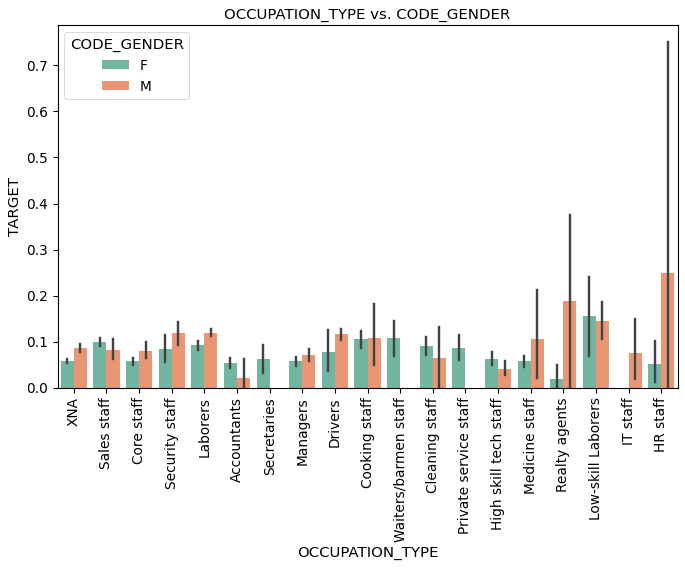

In [89]:
# Occupation type vs Gender
BiVariateCategoryPlot(ad, 'OCCUPATION_TYPE', 'CODE_GENDER', 90)

### Observations: 
- Males (across blue collar jobs) tend to default more than females. 
- Females (across the white collar jobs) tend to default more than males. 

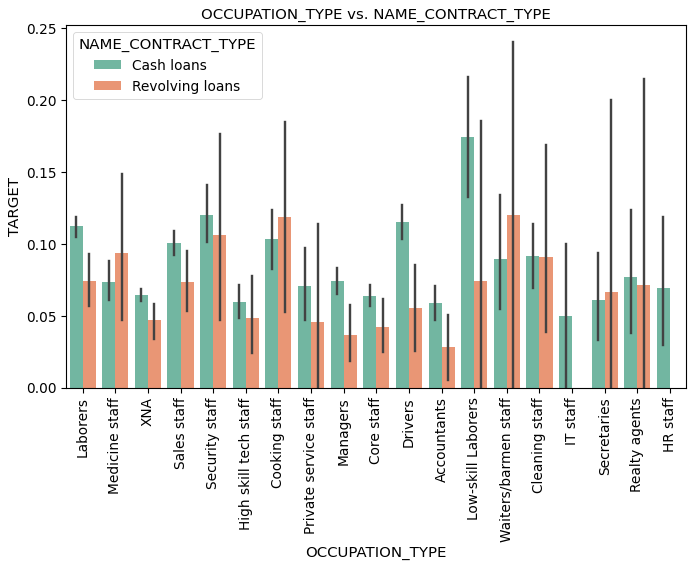

In [90]:
# Occupation type vs Loan Contract Type
BiVariateCategoryPlot(ad, 'OCCUPATION_TYPE', 'NAME_CONTRACT_TYPE', 90)

### Observations: 
- Among the blue collar workers, they tend to default on either cash / revolving loans, but more on the cash loans. 
- Among the white collar workers, they seem to default only on cash loans mostly. 
- The blue collar workers tend to default a lot more than white collar workers. 

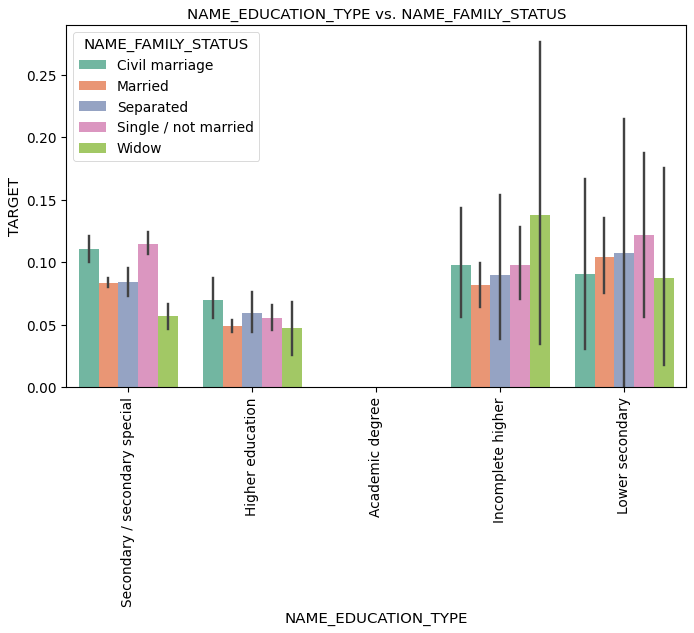

In [91]:
# Education Type vs Family Status
BiVariateCategoryPlot(ad, 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 90)

### Observations: 
- Those with academic degrees have negligible default rate regardless of their family status. This makes sense, since they are generally more well off and more responsible with their loans. 
- People with lower education levels have highest default rates when they are married or single. Single people take more loans for vehicles and apartments for better social standing.  Married people struggle with financial pressures of maintaining a family.  
- The ones who have only completed lower secondary are most likely to default on average. 


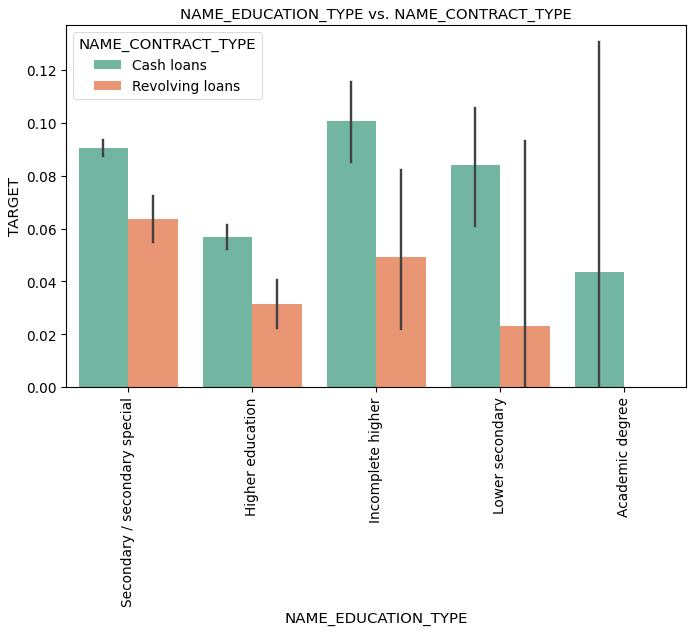

In [92]:
# Education Type vs Loan Contract Type
BiVariateCategoryPlot(ad, 'NAME_EDUCATION_TYPE', 'NAME_CONTRACT_TYPE', 90)

### Observations: 
- A very clear indicator that people (across all education spectrum) are more likely to default on CASH loans rather than revolving loans.  
- When it comes to revolving loans, people with Academic degrees have almost negligible default rate. 



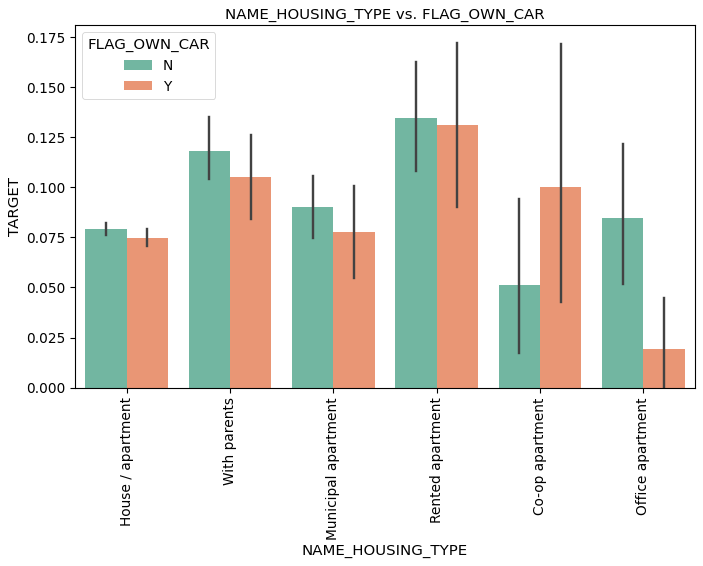

In [93]:
# Housing Type vs Owning a car
BiVariateCategoryPlot(ad, 'NAME_HOUSING_TYPE', 'FLAG_OWN_CAR', 90)

### Observation: 
We see that people living in own house rented apartments or with parents and who do not own a car are more likely to default. That is probably a reflection of their income status where they are still struggling to make ends meet and are not yet in a position to comfortably own a car. 


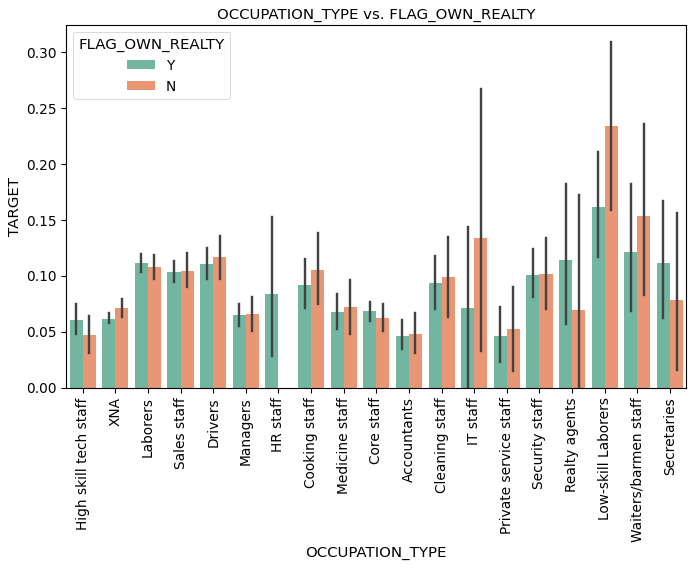

In [94]:
# OCCUPATION_TYPE vs FLAG_OWN_REALTY
BiVariateCategoryPlot(ad, 'OCCUPATION_TYPE', 'FLAG_OWN_REALTY', 90)

### Observation: 
Looking at categories where there is difference between the 2 variables and their 'Defaulting' probability. we observe the following:
- Low Skilled Workers who do not own property yet are highest defaulters (they likely take loans for realty that they are unable to pay back)
- Same with IT Staff who may be freshers looking to own a property; but are not really in a position to pay back the loan. 
- Realty agents also seem to be defaulting (since they are likely managing multiple properties that they take out on lonas and if property does not sell, they might default)
- Other blue-collar worker also tend to default more.  The white collar workers like core st

# 8. DATA ANALYSIS - Merged Data Sets (AD & PA)

## 8.1 Analysis of Merged (AD and PA) Data

In [95]:
# Prevent display of scientific notation. Prefer regular decimal output. 
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [96]:
merge_df = pd.merge(ad, pa, on='SK_ID_CURR', how='inner')

In [97]:
merge_df.head(10)
# Observation: For similarly named columns in both files, columns are appended 
# with "_x" from ad dataset and with "_y" in pa dataset. 

SK_ID_CURR  TARGET_x NAME_CONTRACT_TYPE_x CODE_GENDER FLAG_OWN_CAR  \
0      100002         1           Cash loans           M            N   
1      100003         0           Cash loans           F            N   
2      100003         0           Cash loans           F            N   
3      100003         0           Cash loans           F            N   
4      100004         0      Revolving loans           M            Y   
5      100006         0           Cash loans           F            N   
6      100006         0           Cash loans           F            N   
7      100006         0           Cash loans           F            N   
8      100006         0           Cash loans           F            N   
9      100006         0           Cash loans           F            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT_x  \
0               Y             0        202500.000    406597.500   
1               N             0        270000.000   1293502.500   
2               N             0        270000.000   1293502.500   
3               N             0        270000.000   1293502.500   
4               Y             0         67500.000    135000.000   
5               Y             0        135000.000    312682.500   
6               Y             0        135000.000    312682.500   
7               Y             0        135000.000    312682.500   
8               Y             0        135000.000    312682.500   
9               Y             0        135000.000    312682.500   

   AMT_ANNUITY_x  AMT_GOODS_PRICE_x NAME_TYPE_SUITE_x NAME_INCOME_TYPE  \
0      24700.500         351000.000     Unaccompanied          Working   
1      35698.500        1129500.000            Family    State servant   
2      35698.500        1129500.000            Family    State servant   
3      35698.500        1129500.000            Family    State servant   
4       6750.000         135000.000     Unaccompanied          Working   
5      29686.500         297000.000     Unaccompanied          Working   
6      29686.500         297000.000     Unaccompanied          Working   
7      29686.500         297000.000     Unaccompanied          Working   
8      29686.500         297000.000     Unaccompanied          Working   
9      29686.500         297000.000     Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2               Higher education               Married  House / apartment   
3               Higher education               Married  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   
5  Secondary / secondary special        Civil marriage  House / apartment   
6  Secondary / secondary special        Civil marriage  House / apartment   
7  Secondary / secondary special        Civil marriage  House / apartment   
8  Secondary / secondary special        Civil marriage  House / apartment   
9  Secondary / secondary special        Civil marriage  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                       0.019       -9461       -637.000          -3648.000   
1                       0.004      -16765      -1188.000          -1186.000   
2                       0.004      -16765      -1188.000          -1186.000   
3                       0.004      -16765      -1188.000          -1186.000   
4                       0.010      -19046       -225.000          -4260.000   
5                       0.008      -19005      -3039.000          -9833.000   
6                       0.008      -19005      -3039.000          -9833.000   
7                       0.008      -19005      -3039.000          -9833.000   
8                       0.008      -19005      -3039.000          -9833.000   
9       

In [98]:
merge_df.shape

(1124485, 101)

In [99]:
merge_df.describe()

SK_ID_CURR    TARGET_x  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT_x  \
count 1124485.000 1124485.000   1124485.000       1124485.000   1124485.000   
mean   278433.653       0.086         0.412        172273.731    590161.787   
std    102778.986       0.280         0.723        186698.789    387195.632   
min    100002.000       0.000         0.000         25650.000     45000.000   
25%    189402.000       0.000         0.000        112500.000    270000.000   
50%    278873.000       0.000         0.000        157500.000    509400.000   
75%    367425.000       0.000         1.000        202500.000    808650.000   
max    456255.000       1.000        19.000     117000000.000   4050000.000   

       AMT_ANNUITY_x  AMT_GOODS_PRICE_x  REGION_POPULATION_RELATIVE  \
count    1124485.000        1124485.000                 1124485.000   
mean       27055.124         529919.033                       0.021   
std        13965.253         355181.420                       0.013   
min         1615.500          40500.000                       0.000   
25%        16825.500         238500.000                       0.010   
50%        24939.000         450000.000                       0.019   
75%        34587.000         679500.000                       0.026   
max       225000.000        4050000.000                       0.073   

       DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
count 1124485.000    1124485.000        1124485.000      1124485.000   
mean   -16256.311      -2233.319          -4988.893        -3033.501   
std      4338.095       2146.329           3534.200         1506.748   
min    -25201.000     -17912.000         -24672.000        -7197.000   
25%    -19899.000      -2860.000          -7475.000        -4317.000   
50%    -15959.000      -1305.000          -4497.000        -3328.000   
75%    -12672.000      -1048.000          -2008.000        -1785.000   
max     -7489.000          0.000              0.000            0.000   

       FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
count 1124485.000     1124485.000      1124485.000       1124485.000   
mean        1.000           0.811            0.192             0.999   
std         0.000           0.392            0.394             0.027   
min         1.000           0.000            0.000             0.000   
25%         1.000           1.000            0.000             1.000   
50%         1.000           1.000            0.000             1.000   
75%         1.000           1.000            0.000             1.000   
max         1.000           1.000            1.000             1.000   

       FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
count 1124485.000 1124485.000      1124485.000           1124485.000   
mean        0.290       0.072            2.159                 2.062   
std         0.454       0.259            0.906                 0.496   
min         0.000       0.000            1.000                 1.000   
25%         0.000       0.000            2.000                 2.000   
50%         0.000       0.000            2.000                 2.000   
75%         1.000       0.000            3.000                 2.000   
max         1.000       1.000           20.000                 3.000   

       REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START_x  \
count                  1124485.000                1124485.000   
mean                         2.039                     11.975   
std                          0.489                      3.231   
min                          1.000                      0.000   
25%                          2.000                     10.000   
50%                          2.000                     12.000   
75%                          2.000                     14.000   
max                          3.000                     23.000   

       REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
count                 1124485.000                 1124485

## Observations: 
- For every SK_ID_CURR in application data, there is a corresponding SK_ID_CURR in previous application file. 
- Each SK_ID_CURR is associated with 1 or more SK_ID_PREV which represent a history of loan applications by the customer. 
- Each SK_ID_PREV (previous loan history) has a TARGET variable (renamed to TARGET_x in merged file) that represent the banks decision to approve/refuse the loan. 
- Some columns (with -ve data values) have several +ve "365243" (1000 years) entries where data is not available. If these columns are needed for analysis, we will impute them with "median" of those columns (not the mean, since mean is highly skewed). 


#### Getting value counts of few columns (especially from the pa dataset):

In [100]:
merge_df['TARGET_y'].value_counts()
# We see that almost 24.4% of the loans were refused in previous application data. 

0.000    880663
1.000    243822
Name: TARGET_y, dtype: int64

In [101]:
merge_df['NAME_CONTRACT_TYPE_y'].value_counts()
# Almost 53% of the loans were "consumer loans", 35% were Cash loans and 12% were Revolving loans. 

Consumer loans     597361
Cash loans         403823
Revolving loans    123272
XNA                    29
Name: NAME_CONTRACT_TYPE_y, dtype: int64

In [102]:
merge_df['NAME_CONTRACT_TYPE_x'].value_counts()

Cash loans         1041629
Revolving loans      82856
Name: NAME_CONTRACT_TYPE_x, dtype: int64

In [103]:
merge_df['NAME_CLIENT_TYPE'].value_counts()

Repeater     776221
New          252791
Refreshed     94763
XNA             710
Name: NAME_CLIENT_TYPE, dtype: int64

In [104]:
merge_df['NFLAG_INSURED_ON_APPROVAL'].value_counts()

0.000    567087
1.000    280281
Name: NFLAG_INSURED_ON_APPROVAL, dtype: int64

In [105]:
merge_df['NAME_CONTRACT_TYPE_y'].value_counts()

Consumer loans     597361
Cash loans         403823
Revolving loans    123272
XNA                    29
Name: NAME_CONTRACT_TYPE_y, dtype: int64

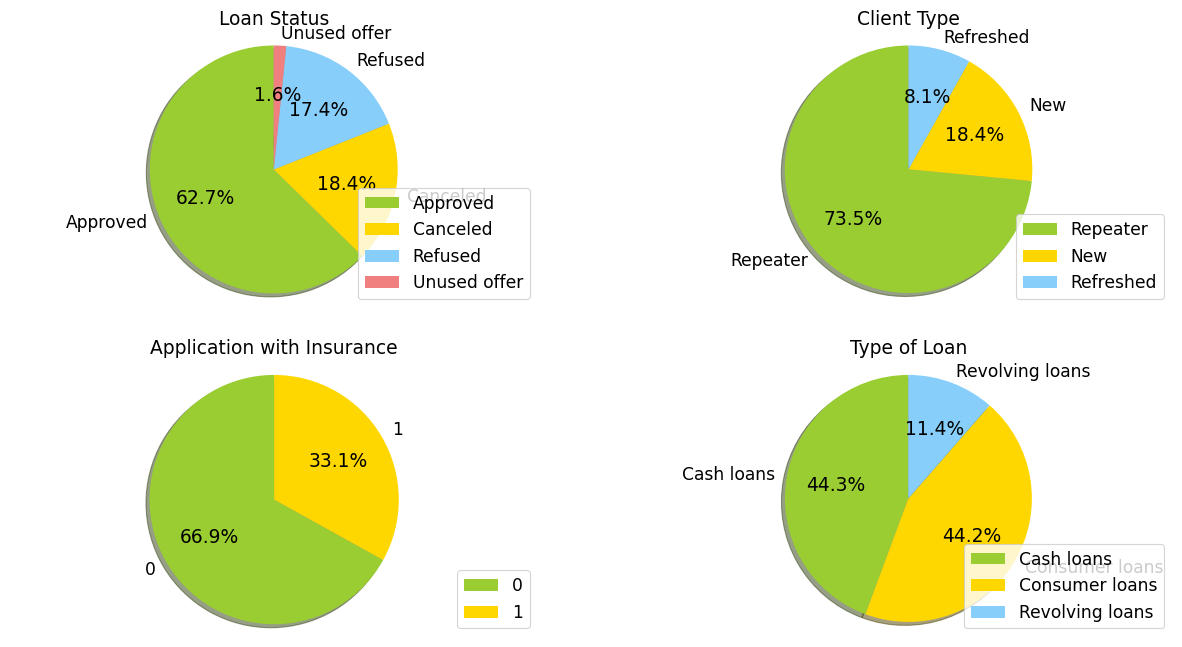

In [106]:
plt.figure(figsize=(15,8), dpi = 100)
plt.subplot(2,2,1)
labels = ['Approved', 'Canceled', 'Refused', 'Unused offer']
sizes = [886099, 259441, 245390, 22771]
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
plt.pie(sizes, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=90)
plt.legend(labels, loc='lower right')
plt.axis('equal')
plt.title("Loan Status")

plt.subplot(2,2,2)
labels = ['Repeater', 'New','Refreshed']
sizes = [1037682, 259540, 114936]
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
plt.pie(sizes, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=90)
plt.legend(labels, loc='lower right')
plt.axis('equal')
plt.title("Client Type")

plt.subplot(2,2,3)
labels = ['0','1']
sizes = [570751, 281844]
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
plt.pie(sizes, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=90)
plt.legend(labels, loc='lower right')
plt.axis('equal')
plt.title("Application with Insurance")

plt.subplot(2,2,4)
labels = ['Cash loans', 'Consumer loans', 'Revolving loans']
sizes = [626764, 625256, 161368]
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
plt.pie(sizes, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=90)
plt.legend(labels, loc='lower right')
plt.axis('equal')
plt.title("Type of Loan")
plt.show()


#### Comparison:
* Approved: 62.7 % 
* Cancelled: 18.9 % 
* Refused: 17.4 % 
* Unused offer: 1.58 %
* 73.5 % were repeater clients who applied for loan previously.
* Approx. 67% clints requested insurance during the previous application
* Cash loans - 44.76 %
* Consumer loans - 43.66 %
* Revolving loan - 11.57 %

## 8.2 Bivariate Analysis on Merged Dataset

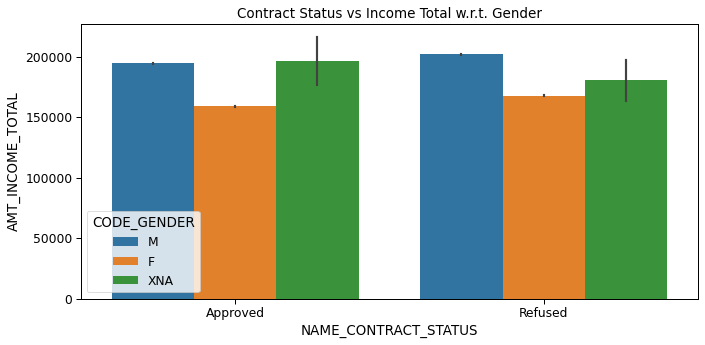

In [107]:
plt.figure(figsize=(10,5))
sns.barplot(x='NAME_CONTRACT_STATUS',y='AMT_INCOME_TOTAL', data=merge_df, hue='CODE_GENDER')
plt.title("Contract Status vs Income Total w.r.t. Gender")
plt.tight_layout()
plt.show()

#### Comparison:
Visualization shows that all four contract statuses for male applicants tend to round off at the 200000 income mark.

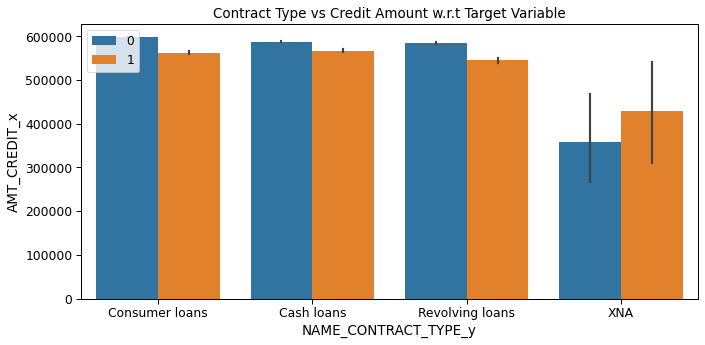

In [111]:
plt.figure(figsize=(10,5))
sns.barplot(x='NAME_CONTRACT_TYPE_y',y='AMT_CREDIT_x', data=merge_df, hue='TARGET_x')
plt.legend(loc='upper left')
plt.title("Contract Type vs Credit Amount w.r.t Target Variable")
plt.tight_layout()
plt.show()

#### Comparison:¶
People taking consumer loans of close to 600000 are likely to both pay on time and default compared to other types.

# 9. Conclusion:

* In 6.1.3 It is an evident that if the categorical variables [PRODUCT_COMBINATION, NAME_YIELD_GROUP, CHANNEL_TYPE,      NAME_PORTFOLIO] contains the categories [cash X-sell: low, XNA, Credit and cash offices, Cash] then the applicant is more likely to become a defaulter and the loan providing company should be more careful in providing loan for these applicants.

    On the other hand, if the above mentioned categorical variables contains the categories [POS household with interest, middle, country-wide, POS] then the is not likely to become a defaulter and the loan providing company should not be cancelling the application in providing the loan for these applicants.
    

* For male applications income (AMT_INCOME_TOTAL) plays a role in becoming a default or not. Higher the income it is likely tobecome defaulter. So the loan lending company should be careful in providing loans for male applicats who has less income.


* In considering the numerical variable AMT_ANNUITY, in both male and female, if the value of AMT_ANNUITY is less then the       applicants are most likely to become defaulters, so the lending company should be more careful in lending loans to these       applicants.


* In considering the numerical variable AMT_GOODS_PRICE, in both male and female, if the value of AMT_GOODS_PRICE is less then   the applicants are most likely to become defaulters, so the lending company should be more careful in lending loans to these   applicants.


* In considering the numerical variable AMT_APPLICATION, in general, if the value of AMT_APPLICATION is high then the applicants are most likely to become defaulters, so the lending company should be more careful in lending loans to these applicants.